# MCA Dimensionality Reduction

This technique consider only categorical variables. Some of our variables are numerical (age, weight of the surveyed people, household spent on prepared meals and food to prepare at home, and number of members at home split by kids and adults). Except by the weight, the rest of variables are transformed to categories to be included in the analysis. Additionally, the variables related to the health insurance coverage are put together as one insurance variable.  

The object of correspondence analysis (CA) is to analyze categorical/categorized data that are transformed into cross tables and to demonstrate the results in a graphical manner. In CA, both relations between row and column variables and relations between different levels of each variable can be obtained [2–7]. Some considerations regarding CA are warranted particularly regarding the influence of cells and responses. For instance, some reports have:
- Explored the impact on the analysis by including and excluding/deleting categories 
- Examined methods for identifying columns (attributes) that highlight row (incidence) differences.
Source: https://www.hindawi.com/journals/jar/2013/302163/

Notes: To improve the performance, the category EST was deleted because it adds 50 extra categories.

MCA 

To perform the following technique, we ignore this column and all the variables are converted in categorical (both ordinal and nominal variables are represented by float and int types until now).

In this section, we are focusing on how to apply the MCA reduction dimensionality technique to get a representation of the data points in handle dimensions.

1. Be able to visualize the datapoints in 2D dimensions using different variables as label: In this way, we can find where the datapoints are in the new space and how the variables are connected between them.
2. Be able to explain correlations between the variables and the coordinates generates
3. Visualize the distance between the variables in the hyperplane.



A projection in 2D is not neccesarily the most appropiate when we are investigating correlations and mathematical relations between the variables. 

In [1]:
import pandas as pd
import numpy as np
import warnings
import random
import matplotlib.pyplot as plt
import seaborn as sns
import math

warnings.filterwarnings("ignore")

In [2]:
import sys
#!{sys.executable} -m pip install kmodes
#!{sys.executable} -m pip install --user prince
from kmodes.kmodes import KModes
from sklearn.decomposition import FactorAnalysis
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import fcluster
import prince #MCA

# 1. Read the dataset, delete the contextual variables and apply the same preprocessing steps used for the chi-squared statistical tests for feature selection.

In [3]:
df_pulse = pd.read_csv('../data/interim/pulse2020_puf_all.csv')

In [4]:
df_pulse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197365 entries, 0 to 1197364
Columns: 207 entries, SCRAM to depression_disorder
dtypes: bool(2), float64(203), object(2)
memory usage: 1.8+ GB


In [5]:
secondary_columns = [
                    'KINDWORK',
                    'RSNNOWRK',
                    'UNEMPPAY',
                    'FOODSUFRSN1',
                    'FOODSUFRSN2',
                    'FOODSUFRSN3',
                    'FOODSUFRSN4',
                    'FOODSUFRSN5',
                    'WHEREFREE1',
                    'WHEREFREE2',
                    'WHEREFREE3',
                    'WHEREFREE4',
                    'WHEREFREE5',
                    'WHEREFREE6',
                    'WHEREFREE7',
                    'FOODCONF',
                    'MORTLMTH',
                    'MORTCONF',
                    'TEACH1',
                    'TEACH2',
                    'TEACH3',
                    'TEACH4',
                    'TEACH5',
                    'COMPAVAIL',
                    'COMP1',
                    'COMP2',
                    'COMP3',
                    'INTRNTAVAIL',
                    'INTRNT1',
                    'INTRNT2',
                    'INTRNT3',
                    'TSCHLHRS',
                    'TTCH_HRS'
                    ]

In [6]:
print('Number of contextual variables: {}'.format(len(secondary_columns)))

Number of contextual variables: 33


Deleting contextual variables

In [7]:
df_universal = df_pulse.drop(columns=secondary_columns)

As we use `anxiety_disorder` and `depression_disorder` variables, the use of `ANXIOUS`, `INTEREST`, `DOWN` and `WORRY` is redundant.

Drop columns when they have lost up to 50% of information (testing different thresholds)

In [8]:
threshold = int(0.5*len(df_universal))
threshold

598682

In [9]:
df_universal1 = df_universal.dropna(axis=1, thresh=threshold)

Drop id surveyed (SCRAM), WEEK, and variables `ANXIOUS`, `WORRY` (used to estimate the ANXIETY DISORDER) and `DOWN`, `INTEREST` (used to score DEPRESSION DISORDER).

In [10]:
df_universal1.drop(columns=['SCRAM', 'WEEK', 'ANXIOUS', 'WORRY', 'DOWN', 'INTEREST'], inplace=True)

Drop duplicates and missing datapoints

In [11]:
df_universal1.drop_duplicates(inplace=True) #The techniques below explote with missing data!

In [12]:
df_universal1.shape

(1197252, 41)

In [13]:
df_universal1.dropna(inplace=True)

In [14]:
df_universal1.head()

EST_ST      PWEIGHT  ABIRTH_YEAR  EGENDER  AGENDER  RHISPANIC  AHISPANIC  \
0    47.0  1973.489532          2.0      2.0      2.0        1.0        2.0   
2    26.0  1526.612380          2.0      2.0      2.0        1.0        2.0   
3     1.0  2734.635354          2.0      1.0      2.0        1.0        2.0   
4     1.0   681.211425          2.0      2.0      2.0        1.0        2.0   
6     1.0  1647.093908          2.0      2.0      2.0        1.0        2.0   

   RRACE  ARACE  EEDUC  ...  HLTHINS6  HLTHINS7  HLTHINS8  DELAY  NOTGET  \
0    1.0    2.0    6.0  ...       2.0       2.0       2.0    2.0     2.0   
2    4.0    2.0    6.0  ...       2.0       2.0       2.0    1.0     1.0   
3    1.0    2.0    4.0  ...       2.0       2.0       1.0    1.0     1.0   
4    1.0    2.0    7.0  ...       2.0       2.0       2.0    2.0     2.0   
6    2.0    2.0    7.0  ...       2.0       2.0       2.0    2.0     2.0   

   TENURE  INCOME   AGE  anxiety_disorder  depression_disorder  
0     3.0     4.0  34.0              True                False  
2     2.0     8.0  44.0             False                False  
3     2.0     1.0  56.0              True                 True  
4     2.0     4.0  57.0             False                False  
6     3.0     4.0  37.0             False                False  

[5 rows x 41 columns]

Sampling data (the advantage of PCA is that it's computationally cheap related to other techniques. To avoid explosions, we use a sample of the dataset).

In [15]:
#Xsample = df_universal1.sample(10000, random_state=42)
Xsample = df_universal1

# 2. Transformation of variables

In [16]:
Xsample.columns

Index(['EST_ST', 'PWEIGHT', 'ABIRTH_YEAR', 'EGENDER', 'AGENDER', 'RHISPANIC',
       'AHISPANIC', 'RRACE', 'ARACE', 'EEDUC', 'AEDUC', 'MS', 'THHLD_NUMPER',
       'AHHLD_NUMPER', 'THHLD_NUMKID', 'AHHLD_NUMKID', 'THHLD_NUMADLT',
       'WRKLOSS', 'EXPCTLOSS', 'ANYWORK', 'PRIFOODSUF', 'CURFOODSUF',
       'FREEFOOD', 'TSPNDFOOD', 'TSPNDPRPD', 'HLTHSTATUS', 'HLTHINS1',
       'HLTHINS2', 'HLTHINS3', 'HLTHINS4', 'HLTHINS5', 'HLTHINS6', 'HLTHINS7',
       'HLTHINS8', 'DELAY', 'NOTGET', 'TENURE', 'INCOME', 'AGE',
       'anxiety_disorder', 'depression_disorder'],
      dtype='object')

In [17]:
# Delete flag variables
flag_allocation = ['ABIRTH_YEAR', 'AGENDER', 'AHISPANIC', 'ARACE', 'AEDUC', 'AHHLD_NUMPER', 'AHHLD_NUMKID']
Xsample.drop(columns=flag_allocation, inplace=True)

In [18]:
#dataset for MCA
Xs = Xsample.reset_index(drop=True)

Let's inpect the data:

1. Number of variables
2. Sum of categorical variables

In [19]:
Xs.columns

Index(['EST_ST', 'PWEIGHT', 'EGENDER', 'RHISPANIC', 'RRACE', 'EEDUC', 'MS',
       'THHLD_NUMPER', 'THHLD_NUMKID', 'THHLD_NUMADLT', 'WRKLOSS', 'EXPCTLOSS',
       'ANYWORK', 'PRIFOODSUF', 'CURFOODSUF', 'FREEFOOD', 'TSPNDFOOD',
       'TSPNDPRPD', 'HLTHSTATUS', 'HLTHINS1', 'HLTHINS2', 'HLTHINS3',
       'HLTHINS4', 'HLTHINS5', 'HLTHINS6', 'HLTHINS7', 'HLTHINS8', 'DELAY',
       'NOTGET', 'TENURE', 'INCOME', 'AGE', 'anxiety_disorder',
       'depression_disorder'],
      dtype='object')

In [20]:
Xs.loc[:, 'HLTHINS1':'HLTHINS8']

HLTHINS1  HLTHINS2  HLTHINS3  HLTHINS4  HLTHINS5  HLTHINS6  HLTHINS7  \
0            1.0       2.0       2.0       2.0       2.0       2.0       2.0   
1            1.0       2.0       2.0       2.0       2.0       2.0       2.0   
2            2.0       2.0       2.0       2.0       2.0       2.0       2.0   
3            1.0       2.0       2.0       2.0       2.0       2.0       2.0   
4            1.0       1.0       2.0       2.0       2.0       2.0       2.0   
...          ...       ...       ...       ...       ...       ...       ...   
790961       1.0       1.0       2.0       2.0       2.0       2.0       2.0   
790962       2.0       2.0       2.0       1.0       2.0       2.0       2.0   
790963       1.0       2.0       2.0       2.0       2.0       2.0       2.0   
790964       2.0       1.0       1.0       2.0       2.0       2.0       2.0   
790965       2.0       1.0       2.0       2.0       2.0       2.0       2.0   

        HLTHINS8  
0            2.0  
1            2.0  
2            1.0  
3            2.0  
4            2.0  
...          ...  
790961       2.0  
790962       2.0  
790963       2.0  
790964       2.0  
790965       2.0  

[790966 rows x 8 columns]

In [21]:
x = Xs.loc[:, 'HLTHINS1':'HLTHINS8'].idxmax(axis=1)
Xs['HLTHINS'] = x
Xs.drop(columns=['HLTHINS1','HLTHINS2',
                 'HLTHINS3','HLTHINS4',
                 'HLTHINS5','HLTHINS6',
                 'HLTHINS7','HLTHINS8'], inplace=True)

In [22]:
Xsample.THHLD_NUMPER.unique()

array([ 4.,  2.,  1.,  3.,  5.,  7.,  8.,  6., 10.,  9.])

In [23]:
Xsample.THHLD_NUMADLT.unique()

array([ 2.,  1.,  3.,  4.,  5.,  6., 10.,  7.,  8.,  9.])

In [24]:
Xsample.THHLD_NUMKID.unique()

array([2., 0., 1., 5., 4., 3.])

(array([130292., 282679., 139869., 131090.,  61041.,  25015.,   9206.,
          3851.,   1511.,   6412.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

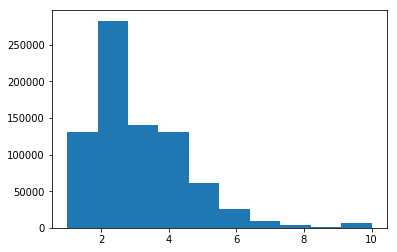

In [25]:
plt.hist(Xsample.THHLD_NUMPER)

(array([1.69127e+05, 4.41837e+05, 1.11176e+05, 4.58330e+04, 1.34020e+04,
        3.52900e+03, 9.94000e+02, 4.41000e+02, 5.67000e+02, 4.06000e+03]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

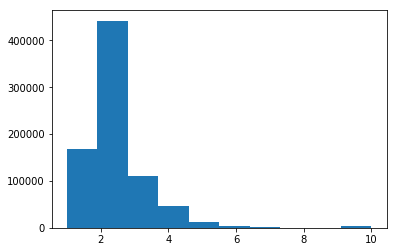

In [26]:
plt.hist(Xsample.THHLD_NUMADLT)

(array([497131.,      0., 123621.,      0., 108053.,      0.,  41452.,
             0.,  13781.,   6928.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

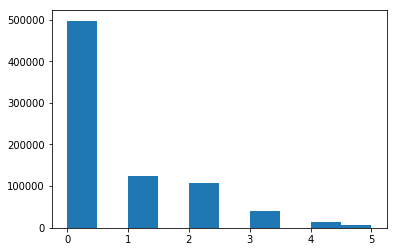

In [27]:
plt.hist(Xsample.THHLD_NUMKID)

In [28]:
def reduce_categories(column):
    #split in 5 categories
    if column < 2:
        return 1.0
    elif (column >= 2) &  (column < 5):
        return 2.0
    elif (column >= 5) &  (column < 7):
        return 3.0
    elif (column >= 7) &  (column < 9):
        return 4.0
    else:
        return 5.0

In [29]:
Xs['NUMADLT'] = Xs.THHLD_NUMADLT.apply(reduce_categories)
Xs['NUMPER'] = Xs.THHLD_NUMPER.apply(reduce_categories)

Xs.drop(columns=['THHLD_NUMPER', 'THHLD_NUMADLT'], inplace=True)

In [30]:
def reduce_categories_food1(column):
    #split in 5 categories
    bins=5
    max_value=900
    thres = int(max_value/bins)
    if column < thres:
        return 1.0
    elif (column >= thres) &  (column < 2*thres):
        return 2.0
    elif (column >= 2*thres) &  (column < 3*thres):
        return 3.0
    elif (column >= 4*thres) &  (column < 5*thres):
        return 4.0
    else:
        return 5.0

In [31]:
def reduce_categories_food2(column):
    #split in 5 categories
    bins=5
    max_value=500
    thres = int(max_value/bins)
    if column < thres:
        return 1.0
    elif (column >= thres) &  (column < 2*thres):
        return 2.0
    elif (column >= 2*thres) &  (column < 3*thres):
        return 3.0
    elif (column >= 4*thres) &  (column < 5*thres):
        return 4.0
    else:
        return 5.0

(array([145674., 280919., 201182.,  89417.,  30068.,  24073.,   7693.,
          3872.,   3497.,   4571.]),
 array([  0.,  90., 180., 270., 360., 450., 540., 630., 720., 810., 900.]),
 <a list of 10 Patch objects>)

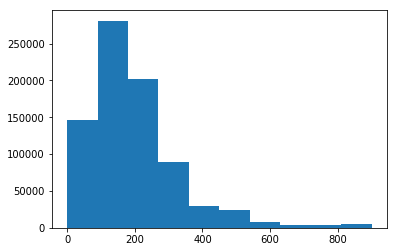

In [32]:
plt.hist(Xsample.TSPNDFOOD)

(array([387612., 181528., 110368.,  37384.,  37261.,   8827.,  12685.,
          2390.,   4556.,   8355.]),
 array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.]),
 <a list of 10 Patch objects>)

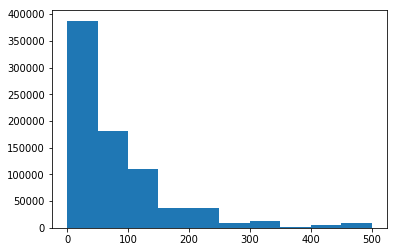

In [33]:
plt.hist(Xsample.TSPNDPRPD)

In [34]:
Xs['TSPFOOD'] = Xs.TSPNDFOOD.apply(reduce_categories_food1)
Xs['TSPPRPD'] = Xs.TSPNDPRPD.apply(reduce_categories_food2)

Xs.drop(columns=['TSPNDFOOD', 'TSPNDPRPD'], inplace=True)

(array([ 22922.,  73181., 121197., 121658., 110155., 105624., 106371.,
         83241.,  36191.,  10426.]),
 array([18., 25., 32., 39., 46., 53., 60., 67., 74., 81., 88.]),
 <a list of 10 Patch objects>)

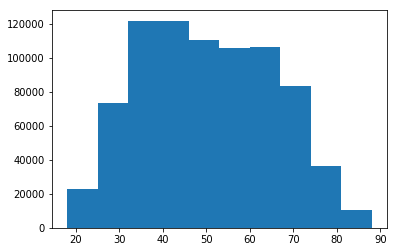

In [35]:
plt.hist(Xsample.AGE)

In [36]:
def bins_age(column):
    #split in 4 categories
    thres = 36
    if column < 36:
        return 1.0
    elif (column >= 36) &  (column < 54):
        return 2.0
    elif (column >= 54) &  (column < 72):
        return 3.0
    else:
        return 4.0

In [37]:
Xs['AGE_CAT'] = Xs.AGE.apply(bins_age)
Xs.drop(columns=['AGE'], inplace=True)

In [38]:
Xs['AGE_CAT'].unique()

array([1., 2., 3., 4.])

In [39]:
Xs = Xs.rename(columns={'anxiety_disorder': 'ANXIETY', 'depression_disorder': 'DEPRESSION'})

# 3. MCA using all the variables (no Delete Anxiety and Depression variables)

In [40]:
X_cat = Xs.drop(columns=['PWEIGHT', 'EST_ST']) #delete the continuous variables and states
df=X_cat.copy()

for var in df.columns:
    df[var]=df[var].astype('category')

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790966 entries, 0 to 790965
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   EGENDER       790966 non-null  category
 1   RHISPANIC     790966 non-null  category
 2   RRACE         790966 non-null  category
 3   EEDUC         790966 non-null  category
 4   MS            790966 non-null  category
 5   THHLD_NUMKID  790966 non-null  category
 6   WRKLOSS       790966 non-null  category
 7   EXPCTLOSS     790966 non-null  category
 8   ANYWORK       790966 non-null  category
 9   PRIFOODSUF    790966 non-null  category
 10  CURFOODSUF    790966 non-null  category
 11  FREEFOOD      790966 non-null  category
 12  HLTHSTATUS    790966 non-null  category
 13  DELAY         790966 non-null  category
 14  NOTGET        790966 non-null  category
 15  TENURE        790966 non-null  category
 16  INCOME        790966 non-null  category
 17  ANXIETY       790966 non-null

In [42]:
total_variables = df.shape[1]

In [43]:
total_categories = 0
for col in df.columns:
    total_categories += df[col].unique().shape[0]  
    
print('Number of categories: {}'.format(total_categories))

Number of categories: 99


In [44]:
max_dimensions = total_categories-total_variables

In [45]:
print('Max number of dimensions: {}'.format(max_dimensions))

Max number of dimensions: 74


In [46]:
total_inertia = max_dimensions/total_variables
print('Total inertia: {}'.format(total_inertia))

Total inertia: 2.96


This step allow exploring the number of dimensions to be included in the analysis and to obtain the reference value for total inertia (meaning that the contribution of each factor should now be calculated using the total inertia score as the denominator). The main use of inertia is as an indicator of the number of axes to retain for further analysis.

To define the number of dimensions to retain, the following criteria/considerations were employed: (i) eigenvalue (inclusion of MCA dimensions with inertia above 0.2 and (iv) although no defined number of dimensions is firmly established, some authors recommend two-dimensional pictures of data (which facilitates and allows for data interpretation).

In [47]:
#selected_variables = ['WRKLOSS','EXPCTLOSS','CURFOODSUF', 'DELAY','NOTGET', 'TENURE', 'INCOME', 'anxiety_disorder']
selected_variables = df.columns #all

In [48]:
df1 = df.loc[:, selected_variables]

In [49]:
mca_ex = prince.MCA(n_components=2, n_iter=3, engine='auto', random_state=42)
mca_ex = mca_ex.fit(df1) # same as calling ca.fs_r(1)
dfmca = mca_ex.transform(df1) # same as calling ca.fs_r_sup(df_new) for *another* test set.
#print(dfmca)

In [50]:
mca_ex.eigenvalues_

[0.16187454549879593, 0.1264480081616046]

In [51]:
mca_ex.total_inertia_

2.96

In [52]:
mca_ex.explained_inertia_

[0.05468734645229592, 0.04271892167621777]

## 3.1 Analysis of variables and graphs

In [53]:
def euclidian_distance(x, y):
    return round(math.sqrt(sum([(a - b) ** 2 for a, b in zip(x, y)])),2)

In [54]:
df_variables_mca = mca_ex.column_coordinates(df1)

In [55]:
df_variables_mca.index

Index(['EGENDER_1.0', 'EGENDER_2.0', 'RHISPANIC_1.0', 'RHISPANIC_2.0',
       'RRACE_1.0', 'RRACE_2.0', 'RRACE_3.0', 'RRACE_4.0', 'EEDUC_1.0',
       'EEDUC_2.0', 'EEDUC_3.0', 'EEDUC_4.0', 'EEDUC_5.0', 'EEDUC_6.0',
       'EEDUC_7.0', 'MS_1.0', 'MS_2.0', 'MS_3.0', 'MS_4.0', 'MS_5.0',
       'THHLD_NUMKID_0.0', 'THHLD_NUMKID_1.0', 'THHLD_NUMKID_2.0',
       'THHLD_NUMKID_3.0', 'THHLD_NUMKID_4.0', 'THHLD_NUMKID_5.0',
       'WRKLOSS_1.0', 'WRKLOSS_2.0', 'EXPCTLOSS_1.0', 'EXPCTLOSS_2.0',
       'ANYWORK_1.0', 'ANYWORK_2.0', 'PRIFOODSUF_1.0', 'PRIFOODSUF_2.0',
       'PRIFOODSUF_3.0', 'PRIFOODSUF_4.0', 'CURFOODSUF_1.0', 'CURFOODSUF_2.0',
       'CURFOODSUF_3.0', 'CURFOODSUF_4.0', 'FREEFOOD_1.0', 'FREEFOOD_2.0',
       'HLTHSTATUS_1.0', 'HLTHSTATUS_2.0', 'HLTHSTATUS_3.0', 'HLTHSTATUS_4.0',
       'HLTHSTATUS_5.0', 'DELAY_1.0', 'DELAY_2.0', 'NOTGET_1.0', 'NOTGET_2.0',
       'TENURE_1.0', 'TENURE_2.0', 'TENURE_3.0', 'TENURE_4.0', 'INCOME_1.0',
       'INCOME_2.0', 'INCOME_3.0', 'INCOME_4.0',

In [56]:
len(df_variables_mca.index)

99

In [57]:
df_variables_mca.rename({'EGENDER_1.0': 'GENDER_MALE',
                  'EGENDER_2.0': 'GENDER_FEMALE',
                  'RHISPANIC_1.0': 'NO HISPANIC', 
                  'RHISPANIC_2.0': 'HISPANIC',
                  'RRACE_1.0': 'RACE_WHITE',
                  'RRACE_2.0': 'RACE_BLACK', 
                  'RRACE_3.0': 'RACE_ASIAN', 
                  'RRACE_4.0': 'RACE_COMBINATION', 
                  'EEDUC_1.0': 'EDUC_LESS_HIGH_SCHOOL',
                  'EEDUC_2.0': 'EDUC_SOME_HIGH_SCHOOL', 
                  'EEDUC_3.0': 'EDUC_HIGH_SCHOOL', 
                  'EEDUC_4.0': 'EDUC_SOME_COLLEGE', 
                  'EEDUC_5.0': 'EDUC_ASSOCIATE', 
                  'EEDUC_6.0': 'EDUC_BACHELOR',
                  'EEDUC_7.0': 'EDUC_GRADUATE', 
                  'MS_1.0': 'MS_MARRIED', 
                  'MS_2.0': 'MS_WIDOWED', 
                  'MS_3.0': 'MS_DIVORCED', 
                  'MS_4.0': 'MS_SEPARATED', 
                  'MS_5.0': 'MS_NEVER_MARRIED',
#                   'THHLD_NUMKID_0.0': '', 
#                   'THHLD_NUMKID_1.0', 
#                   'THHLD_NUMKID_2.0',
#                   'THHLD_NUMKID_3.0', 
#                   'THHLD_NUMKID_4.0', 
#                   'THHLD_NUMKID_5.0',
                  'WRKLOSS_1.0' : 'WRKLOSS_YES', 
                  'WRKLOSS_2.0': 'WRKLOSS_NO', 
                  'EXPCTLOSS_1.0': 'EXPCTLOSS_YES', 
                  'EXPCTLOSS_2.0': 'EXPCTLOSS_NO',
                  'ANYWORK_1.0': 'ANYWORK_YES', 
                  'ANYWORK_2.0': 'ANYWORK_NO', 
                  'PRIFOODSUF_1.0': 'PRIFOODSUF_ENOUGH_DESIRED', 
                  'PRIFOODSUF_2.0': 'PRIFOODSUF_ONLY_ENOUGH',
                  'PRIFOODSUF_3.0': 'PRIFOODSUF_SOMETIMES', 
                  'PRIFOODSUF_4.0': 'PRIFOODSUF_NOT_ENOUGH', 
                  'CURFOODSUF_1.0': 'CURFOODSUF_ENOUGH_DESIRED', 
                  'CURFOODSUF_2.0': 'CURFOODSUF_ONLY_ENOUGH',
                  'CURFOODSUF_3.0': 'CURFOODSUF_SOMETIMES', 
                  'CURFOODSUF_4.0': 'CURFOODSUF_NOT_ENOUGH', 
                  'FREEFOOD_1.0': 'FREEFOOD_YES', 
                  'FREEFOOD_2.0': 'FREEFOOD_NO',
                  'HLTHSTATUS_1.0': 'HLTHSTATUS_EXCELLENT', 
                  'HLTHSTATUS_2.0': 'HLTHSTATUS_VERY_GOOD', 
                  'HLTHSTATUS_3.0': 'HLTHSTATUS_GOOD', 
                  'HLTHSTATUS_4.0': 'HLTHSTATUS_FAIR',
                  'HLTHSTATUS_5.0': 'HLTHSTATUS_POOR', 
                  'DELAY_1.0': 'DELAY_YES', 
                  'DELAY_2.0': 'DELAY_NO', 
                  'NOTGET_1.0': 'NOTGET_TRUE', 
                  'NOTGET_2.0': 'NOTGET_FALSE',
                  'TENURE_1.0': 'OWNED NO M/L', 
                  'TENURE_2.0': 'OWNED M/L', 
                  'TENURE_3.0': 'RENTED', 
                  'TENURE_4.0': 'OCCUPIED', 
                  'INCOME_1.0': 'INCOME <25K',
                  'INCOME_2.0': 'INCOME 25K-34,9K', 
                  'INCOME_3.0': 'INCOME 35K-49,9K', 
                  'INCOME_4.0': 'INCOME 50K-74,9K', 
                  'INCOME_5.0': 'INCOME 75K-99,9K', 
                  'INCOME_6.0': 'INCOME 100K-149,9K',
                  'INCOME_7.0': 'INCOME 150K-199,9K', 
                  'INCOME_8.0': 'INCOME >200K', 
                  'ANXIETY_False': 'ANXIETY_NO', 
                  'ANXIETY_True': 'ANXIETY_YES',
                  'DEPRESSION_False': 'DEPRESSION_NO', 
                  'DEPRESSION_True': 'DEPRESSION_YES', 
                  'HLTHINS_HLTHINS1': 'HLTHINS_EMPLOYER',
                  'HLTHINS_HLTHINS2': 'HLTHINS_INSURANCE', 
                  'HLTHINS_HLTHINS3': 'HLTHINS_65_DISABILITY', 
                  'HLTHINS_HLTHINS4': 'HLTHINS_GOV',
                  'HLTHINS_HLTHINS5': 'HLTHINS_MILITARY', 
                  'HLTHINS_HLTHINS6': 'HLTHINS_VA', 
                  'HLTHINS_HLTHINS7': 'HLTHINS_INDIAN',
                  'HLTHINS_HLTHINS8': 'HLTHINS_OTHER',
                  'NUMADLT_1.0': 'NUMADLT_1', 
                  'NUMADLT_2.0': 'NUMADLT_2-4', 
                  'NUMADLT_3.0': 'NUMADLT_5-6', 
                  'NUMADLT_4.0': 'NUMADLT_7-8',
                  'NUMADLT_5.0': 'NUMADLT >9', 
                  'NUMPER_1.0': 'NUMPER_1', 
                  'NUMPER_2.0': 'NUMPER_2-4', 
                  'NUMPER_3.0': 'NUMPER_5-6', 
                  'NUMPER_4.0': 'NUMPER_7-8',
                  'NUMPER_5.0': 'NUMPER >9', 
                  'TSPFOOD_1.0': 'TSPFOOD < 180K', 
                  'TSPFOOD_2.0': 'TSPFOOD 180K-360K', 
                  'TSPFOOD_3.0': 'TSPFOOD 360K-540K',
                  'TSPFOOD_4.0': 'TSPFOOD 540K-720K', 
                  'TSPFOOD_5.0': 'TSPFOOD >720K', 
                  'TSPPRPD_1.0': 'TSPPRPD <100K', 
                  'TSPPRPD_2.0': 'TSPPRPD 100K-200K',
                  'TSPPRPD_3.0': 'TSPPRPD 200K-300K', 
                  'TSPPRPD_4.0': 'TSPPRPD 300K-400K',
                  'TSPPRPD_5.0': 'TSPPRPD >400K',
                  'AGE_CAT_1.0': 'AGE <36 ',
                  'AGE_CAT_2.0': 'AGE_36-54', 
                  'AGE_CAT_3.0': 'AGE_54-72', 
                  'AGE_CAT_4.0': 'AGE >72'    
}, axis='index', inplace=True)

### 3.1.1 Column coordinates

In [58]:
df_variables_mca.head(20)

0         1
GENDER_MALE           -0.189749  0.044119
GENDER_FEMALE          0.129174 -0.030034
NO HISPANIC           -0.048247  0.055417
HISPANIC               0.522955 -0.600672
RACE_WHITE            -0.089455  0.063337
RACE_BLACK             0.732222 -0.221624
RACE_ASIAN            -0.241683 -0.335074
RACE_COMBINATION       0.606028 -0.423618
EDUC_LESS_HIGH_SCHOOL  1.390668 -0.683744
EDUC_SOME_HIGH_SCHOOL  1.326760 -0.669643
EDUC_HIGH_SCHOOL       0.613935 -0.014921
EDUC_SOME_COLLEGE      0.419423 -0.009077
EDUC_ASSOCIATE         0.250797 -0.022617
EDUC_BACHELOR         -0.262894  0.004650
EDUC_GRADUATE         -0.500074  0.064443
MS_MARRIED            -0.423663 -0.334335
MS_WIDOWED             0.522721  1.492632
MS_DIVORCED            0.578103  0.609426
MS_SEPARATED           1.046243 -0.194739
MS_NEVER_MARRIED       0.558820  0.213296

In [59]:
df_variables_mca.index

Index(['GENDER_MALE', 'GENDER_FEMALE', 'NO HISPANIC', 'HISPANIC', 'RACE_WHITE',
       'RACE_BLACK', 'RACE_ASIAN', 'RACE_COMBINATION', 'EDUC_LESS_HIGH_SCHOOL',
       'EDUC_SOME_HIGH_SCHOOL', 'EDUC_HIGH_SCHOOL', 'EDUC_SOME_COLLEGE',
       'EDUC_ASSOCIATE', 'EDUC_BACHELOR', 'EDUC_GRADUATE', 'MS_MARRIED',
       'MS_WIDOWED', 'MS_DIVORCED', 'MS_SEPARATED', 'MS_NEVER_MARRIED',
       'THHLD_NUMKID_0.0', 'THHLD_NUMKID_1.0', 'THHLD_NUMKID_2.0',
       'THHLD_NUMKID_3.0', 'THHLD_NUMKID_4.0', 'THHLD_NUMKID_5.0',
       'WRKLOSS_YES', 'WRKLOSS_NO', 'EXPCTLOSS_YES', 'EXPCTLOSS_NO',
       'ANYWORK_YES', 'ANYWORK_NO', 'PRIFOODSUF_ENOUGH_DESIRED',
       'PRIFOODSUF_ONLY_ENOUGH', 'PRIFOODSUF_SOMETIMES',
       'PRIFOODSUF_NOT_ENOUGH', 'CURFOODSUF_ENOUGH_DESIRED',
       'CURFOODSUF_ONLY_ENOUGH', 'CURFOODSUF_SOMETIMES',
       'CURFOODSUF_NOT_ENOUGH', 'FREEFOOD_YES', 'FREEFOOD_NO',
       'HLTHSTATUS_EXCELLENT', 'HLTHSTATUS_VERY_GOOD', 'HLTHSTATUS_GOOD',
       'HLTHSTATUS_FAIR', 'HLTHSTATUS_POOR

In [60]:
len(df_variables_mca.index)

99

In [61]:
df_variables_mca['abs_0'] = df_variables_mca[0].apply(abs)
df_variables_mca['abs_1'] = df_variables_mca[1].apply(abs)

In [62]:
df_variables_mca['x_2'] = df_variables_mca['abs_0']*df_variables_mca['abs_0']
df_variables_mca['y_2'] = df_variables_mca['abs_1']*df_variables_mca['abs_1']

### 3.1.2 Squared correlation to the axis

In [63]:
df_variables_mca.sort_values('x_2', ascending=True).head(20)

0         1     abs_0     abs_1       x_2  \
THHLD_NUMKID_1.0       0.003740 -0.528881  0.003740  0.528881  0.000014   
THHLD_NUMKID_3.0       0.008501 -1.281148  0.008501  1.281148  0.000072   
NUMPER_5-6             0.013209 -1.244360  0.013209  1.244360  0.000174   
THHLD_NUMKID_0.0       0.034990  0.468978  0.034990  0.468978  0.001224   
NO HISPANIC           -0.048247  0.055417  0.048247  0.055417  0.002328   
AGE_54-72             -0.049925  0.468695  0.049925  0.468695  0.002492   
HLTHINS_65_DISABILITY -0.059991 -0.454609  0.059991  0.454609  0.003599   
FREEFOOD_NO           -0.060498  0.040861  0.060498  0.040861  0.003660   
AGE_36-54             -0.082210 -0.523628  0.082210  0.523628  0.006759   
INCOME 50K-74,9K       0.084461  0.135705  0.084461  0.135705  0.007134   
TSPPRPD <100K          0.087478  0.203401  0.087478  0.203401  0.007652   
AGE >72               -0.088380  1.240177  0.088380  1.240177  0.007811   
RACE_WHITE            -0.089455  0.063337  0.089455  0.063337  0.008002   
TSPFOOD 360K-540K     -0.119393 -0.842385  0.119393  0.842385  0.014255   
GENDER_FEMALE          0.129174 -0.030034  0.129174  0.030034  0.016686   
TSPPRPD >400K          0.139530 -0.889346  0.139530  0.889346  0.019468   
TSPPRPD 300K-400K      0.161488 -1.027455  0.161488  1.027455  0.026078   
TSPFOOD < 180K         0.164508  0.444446  0.164508  0.444446  0.027063   
HLTHINS_GOV           -0.170491  0.926842  0.170491  0.926842  0.029067   
NUMPER_2-4            -0.175999 -0.116245  0.175999  0.116245  0.030976   

                            y_2  
THHLD_NUMKID_1.0       0.279715  
THHLD_NUMKID_3.0       1.641339  
NUMPER_5-6             1.548431  
THHLD_NUMKID_0.0       0.219940  
NO HISPANIC            0.003071  
AGE_54-72              0.219675  
HLTHINS_65_DISABILITY  0.206669  
FREEFOOD_NO            0.001670  
AGE_36-54              0.274186  
INCOME 50K-74,9K       0.018416  
TSPPRPD <100K          0.041372  
AGE >72                1.538040  
RACE_WHITE             0.004012  
TSPFOOD 360K-540K      0.709613  
GENDER_FEMALE          0.000902  
TSPPRPD >400K          0.790937  
TSPPRPD 300K-400K      1.055665  
TSPFOOD < 180K         0.197532  
HLTHINS_GOV            0.859036  
NUMPER_2-4             0.013513

In [64]:
df_variables_mca['origin_distance'] = df_variables_mca[['abs_0', 'abs_1']].apply(lambda x: euclidian_distance((x['abs_0'], x['abs_1']), (0,0)), axis=1)

### 3.1.3 Variables more related to the dimension 1 (they contribute more to the axis)

In [65]:
df_variables_mca.sort_values('abs_0', ascending=True).head(20)

0         1     abs_0     abs_1       x_2  \
THHLD_NUMKID_1.0       0.003740 -0.528881  0.003740  0.528881  0.000014   
THHLD_NUMKID_3.0       0.008501 -1.281148  0.008501  1.281148  0.000072   
NUMPER_5-6             0.013209 -1.244360  0.013209  1.244360  0.000174   
THHLD_NUMKID_0.0       0.034990  0.468978  0.034990  0.468978  0.001224   
NO HISPANIC           -0.048247  0.055417  0.048247  0.055417  0.002328   
AGE_54-72             -0.049925  0.468695  0.049925  0.468695  0.002492   
HLTHINS_65_DISABILITY -0.059991 -0.454609  0.059991  0.454609  0.003599   
FREEFOOD_NO           -0.060498  0.040861  0.060498  0.040861  0.003660   
AGE_36-54             -0.082210 -0.523628  0.082210  0.523628  0.006759   
INCOME 50K-74,9K       0.084461  0.135705  0.084461  0.135705  0.007134   
TSPPRPD <100K          0.087478  0.203401  0.087478  0.203401  0.007652   
AGE >72               -0.088380  1.240177  0.088380  1.240177  0.007811   
RACE_WHITE            -0.089455  0.063337  0.089455  0.063337  0.008002   
TSPFOOD 360K-540K     -0.119393 -0.842385  0.119393  0.842385  0.014255   
GENDER_FEMALE          0.129174 -0.030034  0.129174  0.030034  0.016686   
TSPPRPD >400K          0.139530 -0.889346  0.139530  0.889346  0.019468   
TSPPRPD 300K-400K      0.161488 -1.027455  0.161488  1.027455  0.026078   
TSPFOOD < 180K         0.164508  0.444446  0.164508  0.444446  0.027063   
HLTHINS_GOV           -0.170491  0.926842  0.170491  0.926842  0.029067   
NUMPER_2-4            -0.175999 -0.116245  0.175999  0.116245  0.030976   

                            y_2  origin_distance  
THHLD_NUMKID_1.0       0.279715             0.53  
THHLD_NUMKID_3.0       1.641339             1.28  
NUMPER_5-6             1.548431             1.24  
THHLD_NUMKID_0.0       0.219940             0.47  
NO HISPANIC            0.003071             0.07  
AGE_54-72              0.219675             0.47  
HLTHINS_65_DISABILITY  0.206669             0.46  
FREEFOOD_NO            0.001670             0.07  
AGE_36-54              0.274186             0.53  
INCOME 50K-74,9K       0.018416             0.16  
TSPPRPD <100K          0.041372             0.22  
AGE >72                1.538040             1.24  
RACE_WHITE             0.004012             0.11  
TSPFOOD 360K-540K      0.709613             0.85  
GENDER_FEMALE          0.000902             0.13  
TSPPRPD >400K          0.790937             0.90  
TSPPRPD 300K-400K      1.055665             1.04  
TSPFOOD < 180K         0.197532             0.47  
HLTHINS_GOV            0.859036             0.94  
NUMPER_2-4             0.013513             0.21

### 3.1.4 Variables more related to the dimension 0 (they contribute more to the axis)

In [66]:
df_variables_mca.sort_values('abs_1', ascending=True).head(20)

0         1     abs_0     abs_1       x_2  \
EDUC_BACHELOR        -0.262894  0.004650  0.262894  0.004650  0.069114   
EDUC_SOME_COLLEGE     0.419423 -0.009077  0.419423  0.009077  0.175915   
EDUC_HIGH_SCHOOL      0.613935 -0.014921  0.613935  0.014921  0.376916   
INCOME 75K-99,9K     -0.249629  0.016388  0.249629  0.016388  0.062315   
HLTHSTATUS_POOR       1.564872  0.016517  1.564872  0.016517  2.448826   
RENTED                0.734330  0.019244  0.734330  0.019244  0.539240   
EDUC_ASSOCIATE        0.250797 -0.022617  0.250797  0.022617  0.062899   
HLTHINS_VA            0.627626 -0.022850  0.627626  0.022850  0.393915   
HLTHSTATUS_EXCELLENT -0.584602 -0.026891  0.584602  0.026891  0.341760   
NUMPER >9             0.679377  0.027039  0.679377  0.027039  0.461554   
HLTHSTATUS_GOOD       0.292231 -0.028617  0.292231  0.028617  0.085399   
GENDER_FEMALE         0.129174 -0.030034  0.129174  0.030034  0.016686   
FREEFOOD_NO          -0.060498  0.040861  0.060498  0.040861  0.003660   
GENDER_MALE          -0.189749  0.044119  0.189749  0.044119  0.036005   
HLTHSTATUS_FAIR       0.979290 -0.045993  0.979290  0.045993  0.959009   
HLTHSTATUS_VERY_GOOD -0.292496  0.049938  0.292496  0.049938  0.085554   
NO HISPANIC          -0.048247  0.055417  0.048247  0.055417  0.002328   
RACE_WHITE           -0.089455  0.063337  0.089455  0.063337  0.008002   
EDUC_GRADUATE        -0.500074  0.064443  0.500074  0.064443  0.250074   
DEPRESSION_NO        -0.270623  0.093436  0.270623  0.093436  0.073237   

                           y_2  origin_distance  
EDUC_BACHELOR         0.000022             0.26  
EDUC_SOME_COLLEGE     0.000082             0.42  
EDUC_HIGH_SCHOOL      0.000223             0.61  
INCOME 75K-99,9K      0.000269             0.25  
HLTHSTATUS_POOR       0.000273             1.56  
RENTED                0.000370             0.73  
EDUC_ASSOCIATE        0.000512             0.25  
HLTHINS_VA            0.000522             0.63  
HLTHSTATUS_EXCELLENT  0.000723             0.59  
NUMPER >9             0.000731             0.68  
HLTHSTATUS_GOOD       0.000819             0.29  
GENDER_FEMALE         0.000902             0.13  
FREEFOOD_NO           0.001670             0.07  
GENDER_MALE           0.001946             0.19  
HLTHSTATUS_FAIR       0.002115             0.98  
HLTHSTATUS_VERY_GOOD  0.002494             0.30  
NO HISPANIC           0.003071             0.07  
RACE_WHITE            0.004012             0.11  
EDUC_GRADUATE         0.004153             0.50  
DEPRESSION_NO         0.008730             0.29

### Variables more distant to the origin (special groups)

In [67]:
df_variables_mca.sort_values('origin_distance', ascending=False).loc[:, [0, 1, 'origin_distance']].head(30)

0         1  origin_distance
PRIFOODSUF_NOT_ENOUGH  2.542281 -0.531789             2.60
CURFOODSUF_NOT_ENOUGH  2.444482 -0.519613             2.50
PRIFOODSUF_SOMETIMES   1.949309 -0.623097             2.05
CURFOODSUF_SOMETIMES   1.793740 -0.615384             1.90
HLTHINS_OTHER          0.667031  1.643562             1.77
NUMPER_7-8             0.537723 -1.529374             1.62
NUMPER_1               0.643933  1.467449             1.60
MS_WIDOWED             0.522721  1.492632             1.58
HLTHSTATUS_POOR        1.564872  0.016517             1.56
THHLD_NUMKID_5.0       0.700003 -1.396340             1.56
EDUC_LESS_HIGH_SCHOOL  1.390668 -0.683744             1.55
EDUC_SOME_HIGH_SCHOOL  1.326760 -0.669643             1.49
NUMADLT_7-8            0.959812 -1.101866             1.46
INCOME <25K            1.444984  0.236274             1.46
THHLD_NUMKID_4.0       0.243110 -1.382675             1.40
NUMADLT_5-6            0.442196 -1.234965             1.31
NUMADLT_1              0.655305  1.115929             1.29
THHLD_NUMKID_3.0       0.008501 -1.281148             1.28
TSPFOOD 540K-720K      0.266214 -1.241480             1.27
NUMPER_5-6             0.013209 -1.244360             1.24
AGE >72               -0.088380  1.240177             1.24
OCCUPIED               1.131841  0.207872             1.15
FREEFOOD_YES           0.885523 -0.598092             1.07
MS_SEPARATED           1.046243 -0.194739             1.06
TSPFOOD >720K          0.247934 -1.034397             1.06
TSPPRPD 300K-400K      0.161488 -1.027455             1.04
INCOME >200K          -0.969514 -0.380938             1.04
NUMADLT >9             0.443700  0.930606             1.03
DEPRESSION_YES         0.934979 -0.322815             0.99
HLTHSTATUS_FAIR        0.979290 -0.045993             0.98

### 3.1.5 Distance to the Anxiety and Depression variables

In [68]:
anxiety_true_datapoint = df_variables_mca.loc['ANXIETY_YES', :]
anxiety_false_datapoint = df_variables_mca.loc['ANXIETY_NO', :]
depression_true_datapoint = df_variables_mca.loc['DEPRESSION_YES', :]
depression_false_datapoint = df_variables_mca.loc['DEPRESSION_NO', :]

distance_anxiety_true = []
distance_anxiety_false = []
distance_depression_true = []
distance_depression_false = []

for i in df_variables_mca.index:
    distance_anxiety_true.append(euclidian_distance(anxiety_true_datapoint, df_variables_mca.loc[i, :]))
    distance_anxiety_false.append(euclidian_distance(anxiety_false_datapoint, df_variables_mca.loc[i, :]))
    distance_depression_true.append(euclidian_distance(depression_true_datapoint, df_variables_mca.loc[i, :]))
    distance_depression_false.append(euclidian_distance(depression_false_datapoint, df_variables_mca.loc[i, :]))

In [69]:
df_variables_mca['anxiety_true_distance'] = distance_anxiety_true
df_variables_mca['anxiety_false_distance'] = distance_anxiety_false
df_variables_mca['depression_true_distance'] = distance_depression_true
df_variables_mca['depression_false_distance'] = distance_depression_false

In [70]:
df_variables_mca.head()

0         1     abs_0     abs_1       x_2       y_2  \
GENDER_MALE   -0.189749  0.044119  0.189749  0.044119  0.036005  0.001946   
GENDER_FEMALE  0.129174 -0.030034  0.129174  0.030034  0.016686  0.000902   
NO HISPANIC   -0.048247  0.055417  0.048247  0.055417  0.002328  0.003071   
HISPANIC       0.522955 -0.600672  0.522955  0.600672  0.273482  0.360806   
RACE_WHITE    -0.089455  0.063337  0.089455  0.063337  0.008002  0.004012   

               origin_distance  anxiety_true_distance  anxiety_false_distance  \
GENDER_MALE               0.19                   1.36                    0.29   
GENDER_FEMALE             0.13                   1.23                    0.58   
NO HISPANIC               0.07                   1.41                    0.50   
HISPANIC                  0.80                   0.51                    1.36   
RACE_WHITE                0.11                   1.39                    0.43   

               depression_true_distance  depression_false_distance  
GENDER_MALE                        1.84                       0.17  
GENDER_FEMALE                      1.72                       0.48  
NO HISPANIC                        1.89                       0.39  
HISPANIC                           0.98                       1.36  
RACE_WHITE                         1.87                       0.32

### 3.1.6 Variables closer to Anxiety True

In [71]:
df_variables_mca.loc[:, ['anxiety_true_distance', 'anxiety_false_distance']].sort_values('anxiety_true_distance', ascending=True).head(30)

anxiety_true_distance  anxiety_false_distance
ANXIETY_YES                              0.00                    1.35
PRIFOODSUF_ONLY_ENOUGH                   0.15                    1.40
RACE_COMBINATION                         0.19                    1.26
RACE_BLACK                               0.24                    1.34
EXPCTLOSS_YES                            0.25                    1.37
CURFOODSUF_ONLY_ENOUGH                   0.32                    1.08
HISPANIC                                 0.51                    1.36
WRKLOSS_YES                              0.51                    1.03
NOTGET_TRUE                              0.54                    0.93
HLTHINS_VA                               0.54                    1.10
RENTED                                   0.55                    1.29
NUMPER >9                                0.55                    1.18
HLTHINS_MILITARY                         0.56                    1.21
EDUC_HIGH_SCHOOL                         0.56                    1.07
DEPRESSION_YES                           0.57                    1.80
FREEFOOD_YES                             0.64                    1.91
MS_NEVER_MARRIED                         0.68                    0.96
HLTHINS_EMPLOYER                         0.70                    1.11
INCOME 25K-34,9K                         0.73                    1.57
INCOME 35K-49,9K                         0.76                    0.88
EDUC_SOME_COLLEGE                        0.80                    0.78
HLTHSTATUS_FAIR                          0.81                    1.82
AGE <36                                  0.82                    0.75
DELAY_YES                                0.85                    0.72
MS_SEPARATED                             0.88                    2.00
ANYWORK_NO                               0.89                    0.76
HLTHSTATUS_GOOD                          0.98                    0.65
EDUC_ASSOCIATE                           1.05                    0.62
MS_DIVORCED                              1.06                    1.29
THHLD_NUMKID_1.0                         1.14                    0.95

### Variables closer to Anxiety False

In [72]:
df_variables_mca.loc[:, ['anxiety_true_distance', 'anxiety_false_distance']].sort_values('anxiety_false_distance', ascending=True).head(30)

anxiety_true_distance  anxiety_false_distance
ANXIETY_NO                                  1.35                    0.00
PRIFOODSUF_ENOUGH_DESIRED                   1.34                    0.09
EXPCTLOSS_NO                                1.35                    0.12
DEPRESSION_NO                               1.34                    0.13
NOTGET_FALSE                                1.35                    0.16
HLTHSTATUS_VERY_GOOD                        1.34                    0.17
DELAY_NO                                    1.35                    0.17
WRKLOSS_NO                                  1.36                    0.19
CURFOODSUF_ENOUGH_DESIRED                   1.36                    0.22
INCOME 75K-99,9K                            1.35                    0.25
EDUC_BACHELOR                               1.35                    0.25
GENDER_MALE                                 1.36                    0.29
HLTHINS_INSURANCE                           1.27                    0.31
ANYWORK_YES                                 1.24                    0.37
EDUC_GRADUATE                               1.37                    0.37
NUMPER_2-4                                  1.30                    0.37
RACE_WHITE                                  1.39                    0.43
OWNED M/L                                   1.21                    0.45
TSPPRPD <100K                               1.27                    0.48
NUMADLT_2-4                                 1.20                    0.49
FREEFOOD_NO                                 1.41                    0.49
INCOME 50K-74,9K                            1.29                    0.50
NO HISPANIC                                 1.41                    0.50
RACE_ASIAN                                  1.18                    0.55
HLTHSTATUS_EXCELLENT                        1.39                    0.57
GENDER_FEMALE                               1.23                    0.58
MS_MARRIED                                  1.21                    0.60
INCOME 100K-149,9K                          1.31                    0.60
AGE_54-72                                   1.41                    0.62
EDUC_ASSOCIATE                              1.05                    0.62

### Variables closer to Depression True

In [73]:
df_variables_mca.loc[:, ['depression_true_distance', 'depression_false_distance']].sort_values('depression_true_distance', ascending=True).head(30)

depression_true_distance  depression_false_distance
DEPRESSION_YES                              0.00                       1.81
MS_SEPARATED                                0.34                       2.02
HLTHSTATUS_FAIR                             0.42                       1.83
PRIFOODSUF_ONLY_ENOUGH                      0.46                       1.40
FREEFOOD_YES                                0.48                       1.92
RACE_BLACK                                  0.52                       1.33
ANXIETY_YES                                 0.57                       1.34
INCOME 25K-34,9K                            0.57                       1.60
RENTED                                      0.69                       1.28
EXPCTLOSS_YES                               0.74                       1.37
RACE_COMBINATION                            0.75                       1.26
OCCUPIED                                    0.75                       2.22
HLTHINS_MILITARY                            0.76                       1.21
NUMPER >9                                   0.79                       1.18
CURFOODSUF_ONLY_ENOUGH                      0.84                       1.07
HLTHINS_VA                                  0.86                       1.08
EDUC_HIGH_SCHOOL                            0.89                       1.05
HLTHINS_EMPLOYER                            0.95                       1.14
HISPANIC                                    0.98                       1.36
MS_NEVER_MARRIED                            1.03                       0.98
WRKLOSS_YES                                 1.07                       1.02
NOTGET_TRUE                                 1.10                       0.90
INCOME 35K-49,9K                            1.14                       0.90
EDUC_SOME_COLLEGE                           1.25                       0.74
MS_DIVORCED                                 1.26                       1.36
EDUC_SOME_HIGH_SCHOOL                       1.30                       3.01
ANYWORK_NO                                  1.31                       0.78
AGE <36                                     1.37                       0.71
DELAY_YES                                   1.39                       0.67
HLTHSTATUS_GOOD                             1.46                       0.58

### Variables closer to Depression False

In [74]:
df_variables_mca.loc[:, ['depression_true_distance', 'depression_false_distance']].sort_values('depression_false_distance', ascending=True).head(30)

depression_true_distance  depression_false_distance
DEPRESSION_NO                                  1.81                       0.00
PRIFOODSUF_ENOUGH_DESIRED                      1.80                       0.06
HLTHSTATUS_VERY_GOOD                           1.80                       0.07
INCOME 75K-99,9K                               1.82                       0.12
NOTGET_FALSE                                   1.82                       0.13
ANXIETY_NO                                     1.80                       0.13
EDUC_BACHELOR                                  1.81                       0.13
EXPCTLOSS_NO                                   1.81                       0.15
DELAY_NO                                       1.82                       0.17
GENDER_MALE                                    1.84                       0.17
NUMPER_2-4                                     1.80                       0.27
HLTHINS_INSURANCE                              1.73                       0.28
WRKLOSS_NO                                     1.80                       0.31
ANYWORK_YES                                    1.74                       0.31
RACE_WHITE                                     1.87                       0.32
CURFOODSUF_ENOUGH_DESIRED                      1.77                       0.32
FREEFOOD_NO                                    1.89                       0.38
NO HISPANIC                                    1.89                       0.39
EDUC_GRADUATE                                  1.76                       0.43
INCOME 50K-74,9K                               1.77                       0.43
OWNED M/L                                      1.70                       0.44
TSPPRPD <100K                                  1.75                       0.44
NUMADLT_2-4                                    1.71                       0.45
GENDER_FEMALE                                  1.72                       0.48
RACE_ASIAN                                     1.69                       0.52
EDUC_ASSOCIATE                                 1.53                       0.54
HLTHSTATUS_GOOD                                1.46                       0.58
MS_MARRIED                                     1.67                       0.61
HLTHSTATUS_EXCELLENT                           1.75                       0.62
INCOME 100K-149,9K                             1.70                       0.64

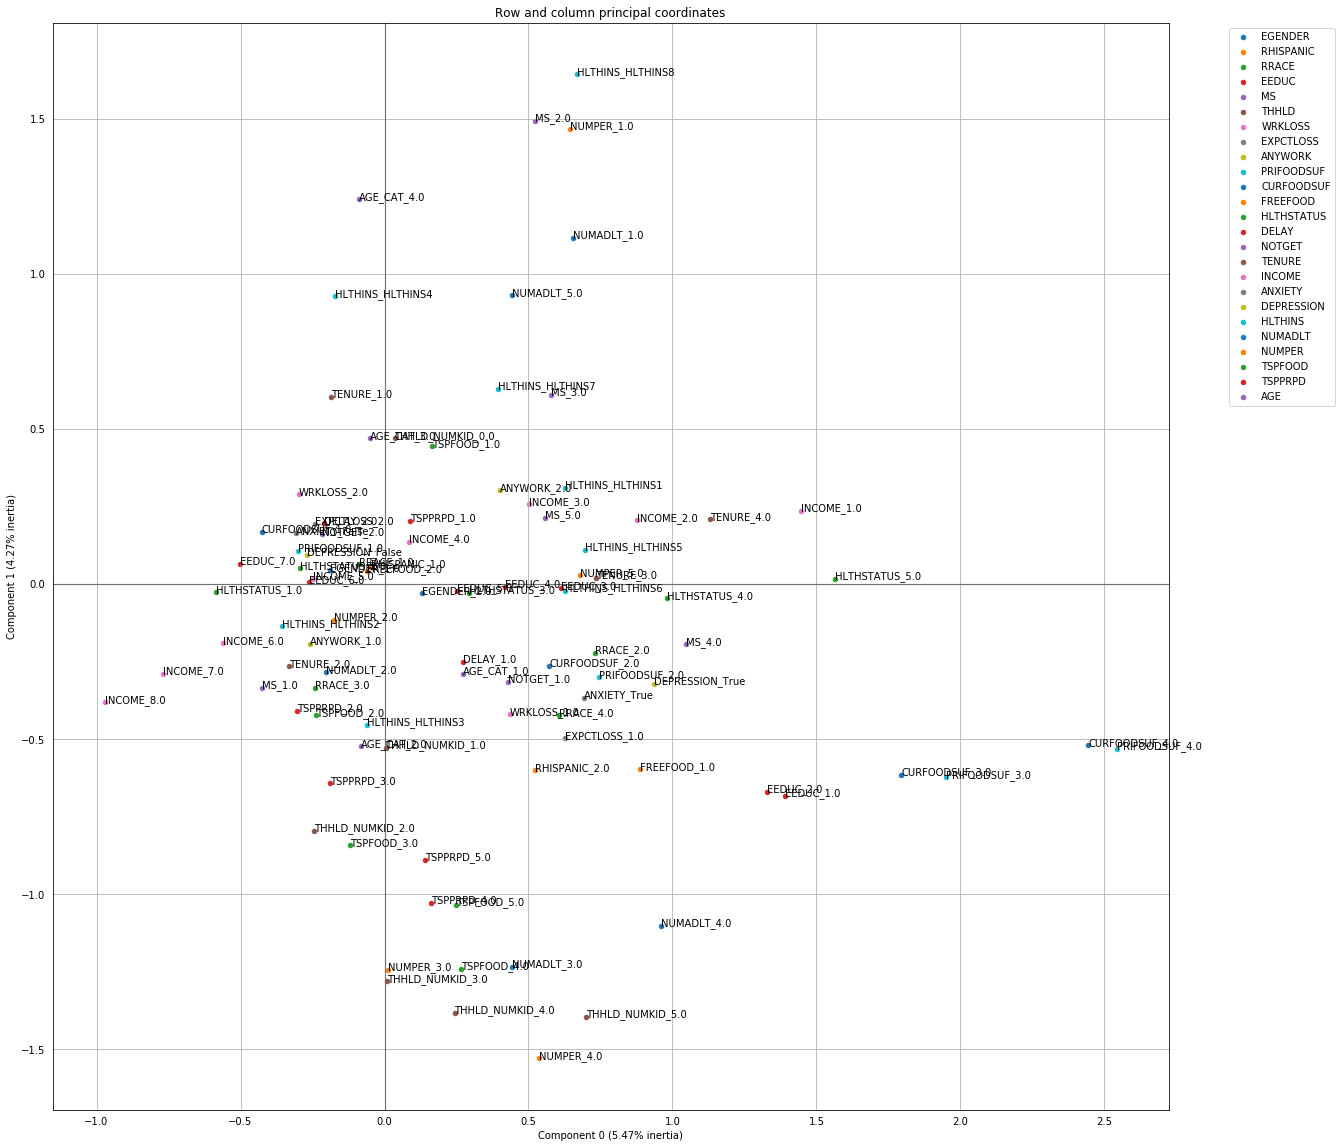

In [75]:
ax = mca_ex.plot_coordinates(
                            X=df1,
                            ax=None,
                            figsize=(20, 20),
                            show_row_points=False,
                            row_points_size=10,
                            show_row_labels=False,
                            show_column_points=True,
                            column_points_size=20,
                            show_column_labels=True,
                            legend_n_cols=1)
ax.get_figure().savefig('mca_coordinates.svg')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

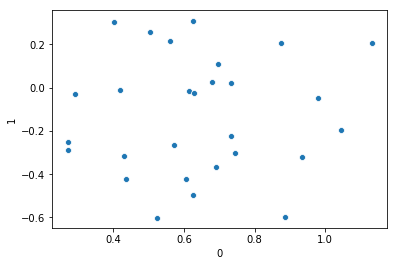

In [76]:
var1 = df_variables_mca[(df_variables_mca.anxiety_true_distance<1) |(df_variables_mca.depression_true_distance<1)].loc[:, [0,1, 'anxiety_true_distance']]
_ = sns.scatterplot(x=var1[0], y=var1[1], )

In [77]:
var1.rename({0:'axis_0', 1:'axis_1'}, axis=1, inplace=True)

In [78]:
var1['variable'] = var1.index

In [79]:
var1.head(30)

axis_0    axis_1  anxiety_true_distance  \
HISPANIC                0.522955 -0.600672                   0.51   
RACE_BLACK              0.732222 -0.221624                   0.24   
RACE_COMBINATION        0.606028 -0.423618                   0.19   
EDUC_HIGH_SCHOOL        0.613935 -0.014921                   0.56   
EDUC_SOME_COLLEGE       0.419423 -0.009077                   0.80   
MS_SEPARATED            1.046243 -0.194739                   0.88   
MS_NEVER_MARRIED        0.558820  0.213296                   0.68   
WRKLOSS_YES             0.434643 -0.420702                   0.51   
EXPCTLOSS_YES           0.626779 -0.498523                   0.25   
ANYWORK_NO              0.401430  0.301164                   0.89   
PRIFOODSUF_ONLY_ENOUGH  0.743223 -0.301168                   0.15   
CURFOODSUF_ONLY_ENOUGH  0.571220 -0.263845                   0.32   
FREEFOOD_YES            0.885523 -0.598092                   0.64   
HLTHSTATUS_GOOD         0.292231 -0.028617                   0.98   
HLTHSTATUS_FAIR         0.979290 -0.045993                   0.81   
DELAY_YES               0.271101 -0.251187                   0.85   
NOTGET_TRUE             0.428730 -0.315358                   0.54   
RENTED                  0.734330  0.019244                   0.55   
OCCUPIED                1.131841  0.207872                   1.24   
INCOME 25K-34,9K        0.875301  0.204613                   0.73   
INCOME 35K-49,9K        0.502090  0.257034                   0.76   
ANXIETY_YES             0.691323 -0.366862                   0.00   
DEPRESSION_YES          0.934979 -0.322815                   0.57   
HLTHINS_EMPLOYER        0.626263  0.309865                   0.70   
HLTHINS_MILITARY        0.697600  0.109835                   0.56   
HLTHINS_VA              0.627626 -0.022850                   0.54   
NUMPER >9               0.679377  0.027039                   0.55   
AGE <36                 0.272168 -0.290379                   0.82   

                                      variable  
HISPANIC                              HISPANIC  
RACE_BLACK                          RACE_BLACK  
RACE_COMBINATION              RACE_COMBINATION  
EDUC_HIGH_SCHOOL              EDUC_HIGH_SCHOOL  
EDUC_SOME_COLLEGE            EDUC_SOME_COLLEGE  
MS_SEPARATED                      MS_SEPARATED  
MS_NEVER_MARRIED              MS_NEVER_MARRIED  
WRKLOSS_YES                        WRKLOSS_YES  
EXPCTLOSS_YES                    EXPCTLOSS_YES  
ANYWORK_NO                          ANYWORK_NO  
PRIFOODSUF_ONLY_ENOUGH  PRIFOODSUF_ONLY_ENOUGH  
CURFOODSUF_ONLY_ENOUGH  CURFOODSUF_ONLY_ENOUGH  
FREEFOOD_YES                      FREEFOOD_YES  
HLTHSTATUS_GOOD                HLTHSTATUS_GOOD  
HLTHSTATUS_FAIR                HLTHSTATUS_FAIR  
DELAY_YES                            DELAY_YES  
NOTGET_TRUE                        NOTGET_TRUE  
RENTED                                  RENTED  
OCCUPIED                              OCCUPIED  
INCOME 25K-34,9K              INCOME 25K-34,9K  
INCOME 35K-49,9K              INCOME 35K-49,9K  
ANXIETY_YES                        ANXIETY_YES  
DEPRESSION_YES                  DEPRESSION_YES  
HLTHINS_EMPLOYER              HLTHINS_EMPLOYER  
HLTHINS_MILITARY              HLTHINS_MILITARY  
HLTHINS_VA                          HLTHINS_VA  
NUMPER >9                            NUMPER >9  
AGE <36                               AGE <36

In [80]:
var1[var1.variable == 'ANXIETY_YES'].loc[:, ['axis_0', 'axis_1']] 

axis_0    axis_1
ANXIETY_YES  0.691323 -0.366862

In [81]:
var1.loc['ANXIETY_YES', ['axis_0', 'axis_1']]

axis_0    0.691323
axis_1   -0.366862
Name: ANXIETY_YES, dtype: object

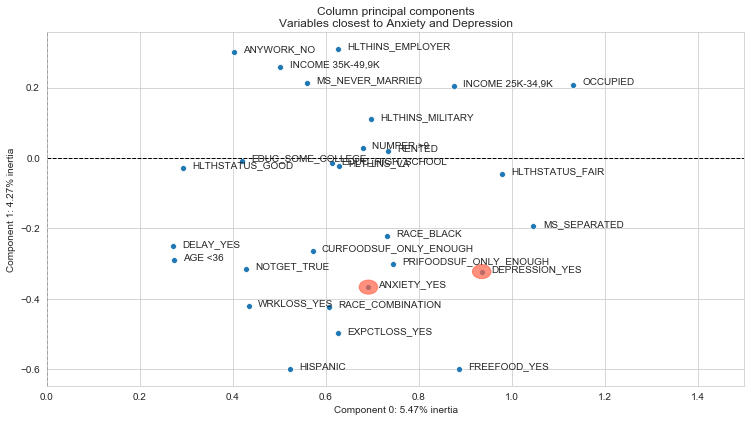

In [82]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12.5, 6.5))

ax = sns.scatterplot(x='axis_0', # Horizontal axis
           y='axis_1', # Vertical axis
           data=var1, # Data source
           #fit_reg=False, # Don't fix a regression line
           #size = 10,
           #aspect =2 
                   ) # size and dimension

plt.title('Column principal components\nVariables closest to Anxiety and Depression')
# Set x-axis label
plt.xlabel('Component 0: 5.47% inertia')
# Set y-axis label
plt.ylabel('Component 1: 4.27% inertia')
cir = plt.Circle(var1.loc['ANXIETY_YES', ['axis_0', 'axis_1']], 
                 0.02, color='tomato',
                 fill=True, 
                 alpha=0.7)
cir1 = plt.Circle(var1.loc['DEPRESSION_YES', ['axis_0', 'axis_1']], 
                 0.02, color='tomato',
                 fill=True, 
                 alpha=0.7)
#ax.set_aspect('equal', adjustable='datalim')
ax.add_patch(cir)
ax.add_patch(cir1)
# ax.set_ylim(-1.6, 1.7)
ax.set_xlim(0, 1.5)

#matplotlib.pyplot.axhline(y=0, xmin=0, xmax=1, hold=None, **kwargs)
plt.axhline(linewidth=1, color='k', linestyle='--') #adds thick red line @ y=0

#matplotlib.pyplot.axvline(x=0, ymin=0, ymax=1, hold=None, **kwargs)
plt.axvline(linewidth=1, color='k', linestyle='--') #adds thick red line @ x=0


def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(var1['axis_0'], var1['axis_1'], var1['variable'], plt.gca())  

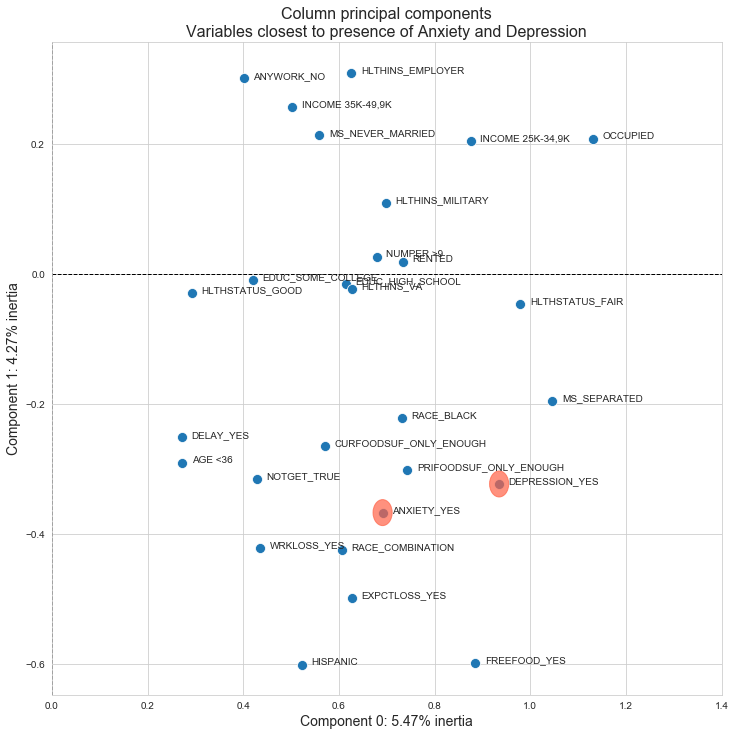

In [83]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 12))

ax = sns.scatterplot(x='axis_0', # Horizontal axis
           y='axis_1', # Vertical axis
           data=var1,
           s=100, 
           #color="skyblue", marker="o"
#            hue='anxiety_true_distance',
           palette='coolwarm',
           legend=False# Data source
           #fit_reg=False, # Don't fix a regression line
           #size = 10,
           #aspect =2 
                   ) # size and dimension

plt.title('Column principal components\nVariables closest to presence of Anxiety and Depression', size=16)
# Set x-axis label
plt.xlabel('Component 0: 5.47% inertia', size=14)
# Set y-axis label
plt.ylabel('Component 1: 4.27% inertia', size=14)
cir = plt.Circle(var1.loc['ANXIETY_YES', ['axis_0', 'axis_1']], 
                 0.02, color='tomato',
                 fill=True, 
                 alpha=0.7)
cir1 = plt.Circle(var1.loc['DEPRESSION_YES', ['axis_0', 'axis_1']], 
                 0.02, color='tomato',
                 fill=True, 
                 alpha=0.7)
#ax.set_aspect('equal', adjustable='datalim')
ax.add_patch(cir)
ax.add_patch(cir1)
# ax.set_ylim(-1.6, 1.7)
ax.set_xlim(0, 1.4)

#matplotlib.pyplot.axhline(y=0, xmin=0, xmax=1, hold=None, **kwargs)
plt.axhline(linewidth=1, color='k', linestyle='--') #adds thick red line @ y=0

#matplotlib.pyplot.axvline(x=0, ymin=0, ymax=1, hold=None, **kwargs)
plt.axvline(linewidth=1, color='k', linestyle='--') #adds thick red line @ x=0

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(var1['axis_0'], var1['axis_1'], var1['variable'], plt.gca())  

In [84]:
var2 = df_variables_mca[((df_variables_mca.anxiety_false_distance<1) |(df_variables_mca.depression_false_distance<1)) & (df_variables_mca[0]<0)].loc[:, [0,1,'anxiety_false_distance']]

In [85]:
var2.rename({0:'axis_0', 1:'axis_1'}, axis=1, inplace=True)

In [86]:
var2['variable'] = var2.index

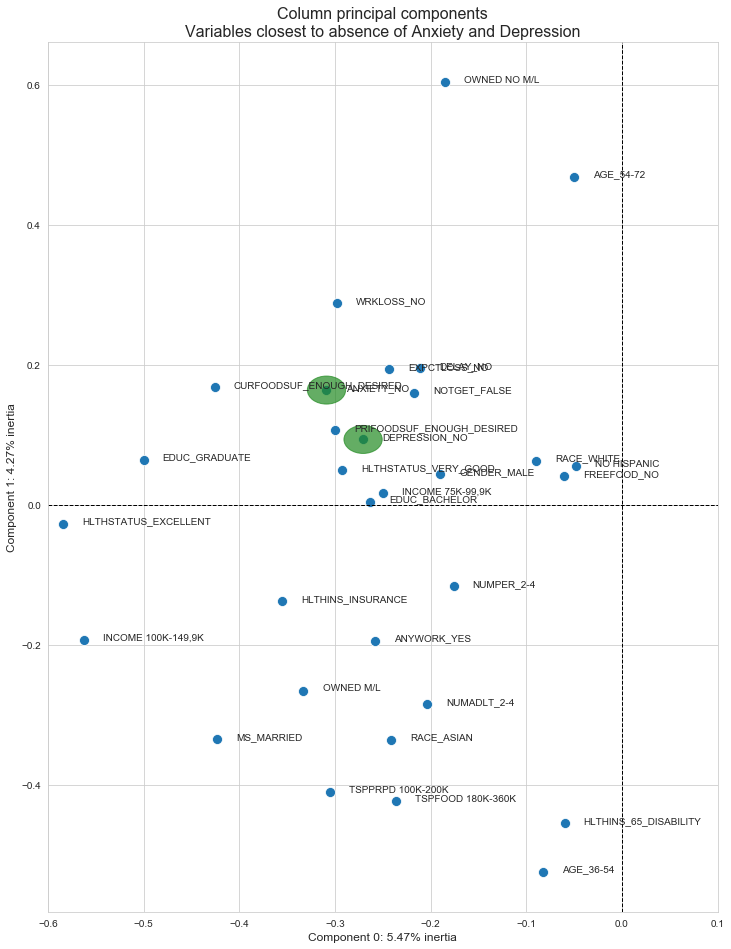

In [87]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 16))

ax = sns.scatterplot(x='axis_0', # Horizontal axis
           y='axis_1', # Vertical axis
           data=var2, # Data source
           s=100, 
           #color="skyblue", marker="o"
#            hue='anxiety_false_distance',
           palette='coolwarm',
           legend=False# Data source
           #fit_reg=False, # Don't fix a regression line
           #size = 10,
           #aspect =2 
                   ) # size and dimension

plt.title('Column principal components\nVariables closest to absence of Anxiety and Depression', size=16)
# Set x-axis label
plt.xlabel('Component 0: 5.47% inertia', size=12)
# Set y-axis label
plt.ylabel('Component 1: 4.27% inertia', size=12)
cir = plt.Circle(var2.loc['ANXIETY_NO', ['axis_0', 'axis_1']], 
                 0.02, color='forestgreen',
                 fill=True, 
                 alpha=0.7)
cir1 = plt.Circle(var2.loc['DEPRESSION_NO', ['axis_0', 'axis_1']], 
                 0.02, color='forestgreen',
                 fill=True, 
                 alpha=0.7)
#ax.set_aspect('equal', adjustable='datalim')
ax.add_patch(cir)
ax.add_patch(cir1)
# ax.set_ylim(-0.3, 0.3)
ax.set_xlim(-0.6, 0.1)

#matplotlib.pyplot.axhline(y=0, xmin=0, xmax=1, hold=None, **kwargs)
plt.axhline(linewidth=1, color='k', linestyle='--') #adds thick red line @ y=0

#matplotlib.pyplot.axvline(x=0, ymin=0, ymax=1, hold=None, **kwargs)
plt.axvline(linewidth=1, color='k', linestyle='--') #adds thick red line @ x=0

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(var2['axis_0'], var2['axis_1'], var2['variable'], plt.gca())  

In [88]:
df_variables_mca

0         1     abs_0     abs_1       x_2       y_2  \
GENDER_MALE   -0.189749  0.044119  0.189749  0.044119  0.036005  0.001946   
GENDER_FEMALE  0.129174 -0.030034  0.129174  0.030034  0.016686  0.000902   
NO HISPANIC   -0.048247  0.055417  0.048247  0.055417  0.002328  0.003071   
HISPANIC       0.522955 -0.600672  0.522955  0.600672  0.273482  0.360806   
RACE_WHITE    -0.089455  0.063337  0.089455  0.063337  0.008002  0.004012   
...                 ...       ...       ...       ...       ...       ...   
TSPPRPD >400K  0.139530 -0.889346  0.139530  0.889346  0.019468  0.790937   
AGE <36        0.272168 -0.290379  0.272168  0.290379  0.074076  0.084320   
AGE_36-54     -0.082210 -0.523628  0.082210  0.523628  0.006759  0.274186   
AGE_54-72     -0.049925  0.468695  0.049925  0.468695  0.002492  0.219675   
AGE >72       -0.088380  1.240177  0.088380  1.240177  0.007811  1.538040   

               origin_distance  anxiety_true_distance  anxiety_false_distance  \
GENDER_MALE               0.19                   1.36                    0.29   
GENDER_FEMALE             0.13                   1.23                    0.58   
NO HISPANIC               0.07                   1.41                    0.50   
HISPANIC                  0.80                   0.51                    1.36   
RACE_WHITE                0.11                   1.39                    0.43   
...                        ...                    ...                     ...   
TSPPRPD >400K             0.90                   1.35                    1.66   
AGE <36                   0.40                   0.82                    0.75   
AGE_36-54                 0.53                   1.15                    0.90   
AGE_54-72                 0.47                   1.41                    0.62   
AGE >72                   1.24                   2.59                    2.34   

               depression_true_distance  depression_false_distance  
GENDER_MALE                        1.84                       0.17  
GENDER_FEMALE                      1.72                       0.48  
NO HISPANIC                        1.89                       0.39  
HISPANIC                           0.98                       1.36  
RACE_WHITE                         1.87                       0.32  
...                                 ...                        ...  
TSPPRPD >400K                      1.77                       1.66  
AGE <36                            1.37                       0.71  
AGE_36-54                          1.68                       0.88  
AGE_54-72                          1.86                       0.68  
AGE >72                            2.81                       2.44  

[99 rows x 11 columns]

In [89]:
df_varall = df_variables_mca.rename({0: 'axis_0', 1: 'axis_1'}, axis=1)
df_varall['variable'] = df_varall.index

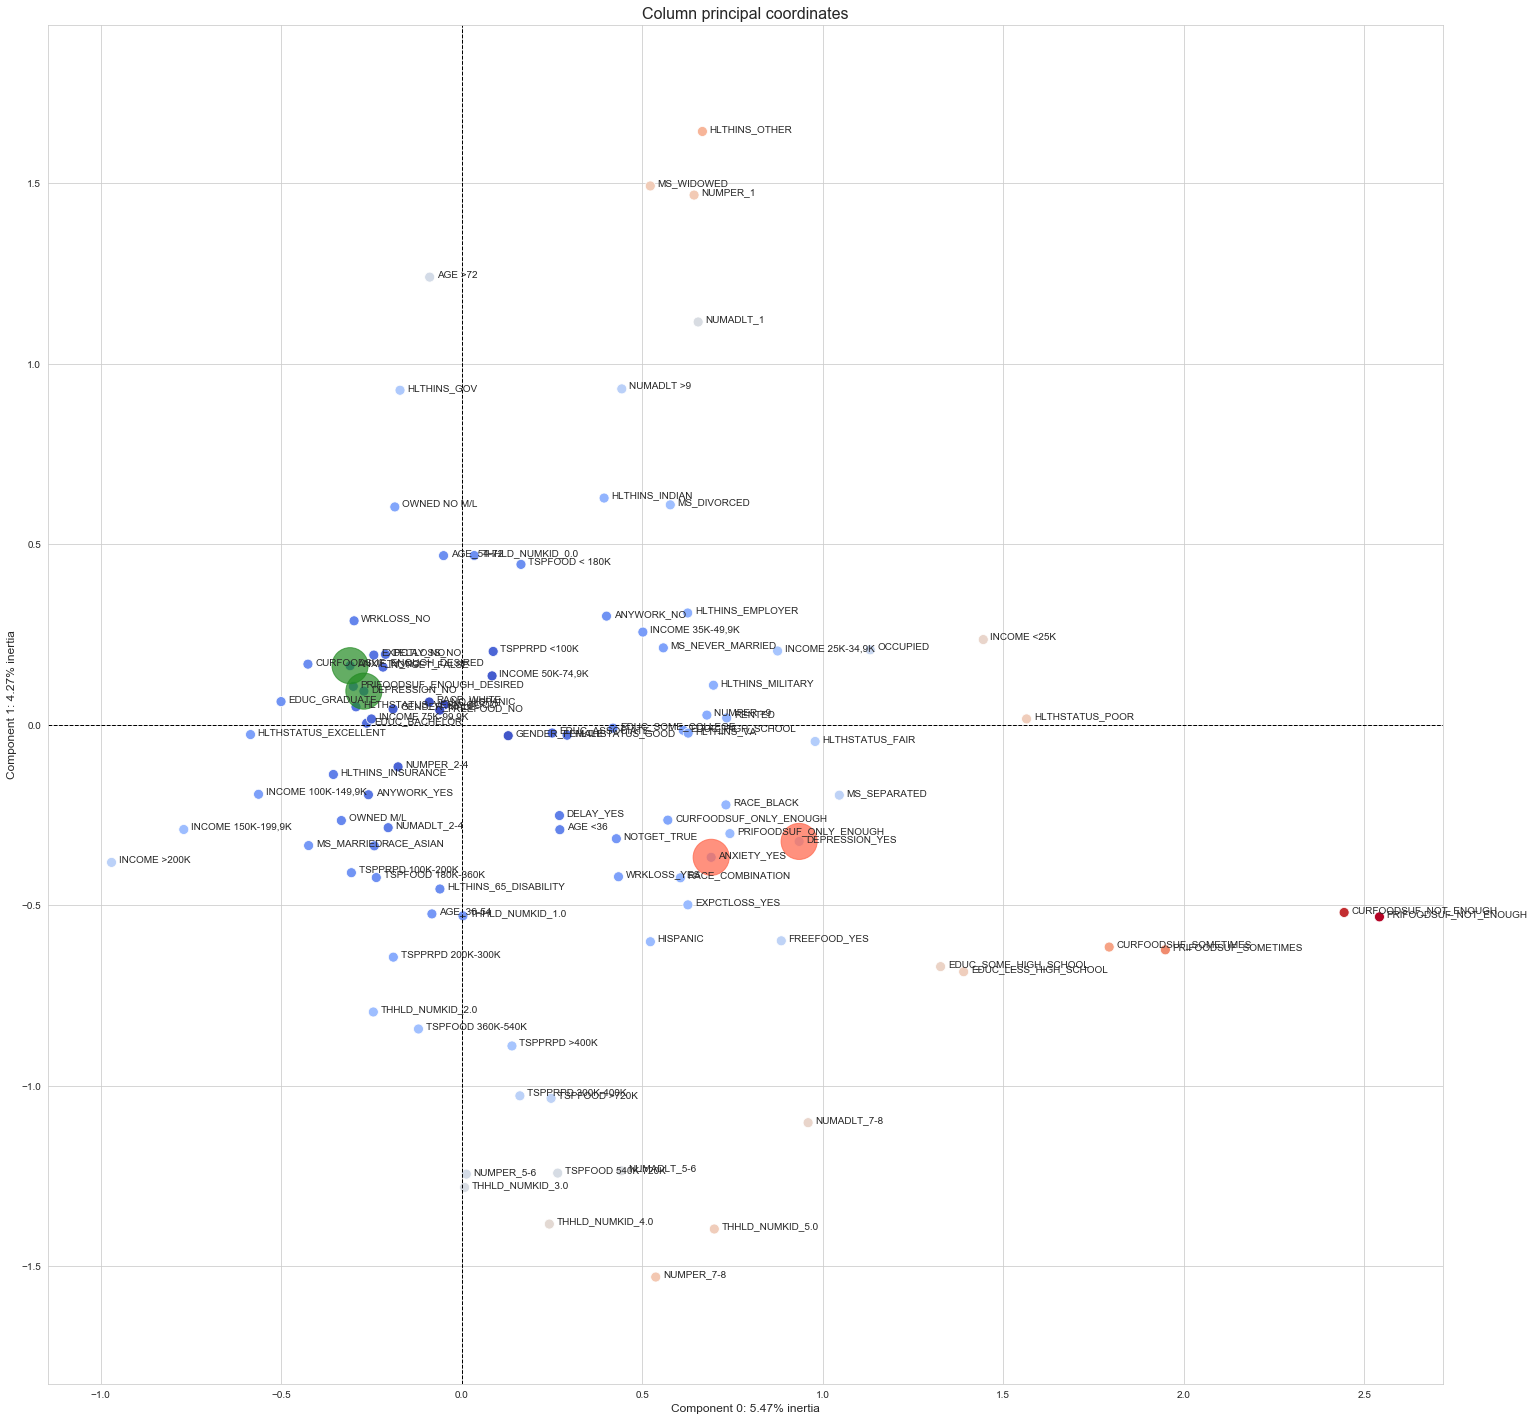

In [97]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(25, 25))

ax = sns.scatterplot(x='axis_0', # Horizontal axis
           y='axis_1', # Vertical axis
           data=df_varall, # Data source
           s=100, 
           #color="skyblue", marker="o"
           hue='origin_distance',
           palette='coolwarm',
           legend=False# Data source
           #fit_reg=False, # Don't fix a regression line
           #size = 10,
           #aspect =2 
                   ) # size and dimension

plt.title('Column principal coordinates', size=16)
# Set x-axis label
plt.xlabel('Component 0: 5.47% inertia', size=12)
# Set y-axis label
plt.ylabel('Component 1: 4.27% inertia', size=12)
cir = plt.Circle(df_varall.loc['ANXIETY_NO', ['axis_0', 'axis_1']], 
                 0.05, color='forestgreen',
                 fill=True, 
                 alpha=0.7)
cir1 = plt.Circle(df_varall.loc['DEPRESSION_NO', ['axis_0', 'axis_1']], 
                 0.05, color='forestgreen',
                 fill=True, 
                 alpha=0.7)
cir2 = plt.Circle(df_varall.loc['ANXIETY_YES', ['axis_0', 'axis_1']], 
                 0.05, color='tomato',
                 fill=True, 
                 alpha=0.7)
cir3 = plt.Circle(df_varall.loc['DEPRESSION_YES', ['axis_0', 'axis_1']], 
                 0.05, color='tomato',
                 fill=True, 
                 alpha=0.7)
ax.set_aspect('equal', adjustable='datalim')
ax.add_patch(cir)
ax.add_patch(cir1)
ax.add_patch(cir2)
ax.add_patch(cir3)
# ax.set_ylim(-0.3, 0.3)
#ax.set_xlim(-0.6, 0.1)

#matplotlib.pyplot.axhline(y=0, xmin=0, xmax=1, hold=None, **kwargs)
plt.axhline(linewidth=1, color='k', linestyle='--') #adds thick red line @ y=0

#matplotlib.pyplot.axvline(x=0, ymin=0, ymax=1, hold=None, **kwargs)
plt.axvline(linewidth=1, color='k', linestyle='--') #adds thick red line @ x=0

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']), fontsize=10)

label_point(df_varall['axis_0'], df_varall['axis_1'], df_varall['variable'], plt.gca())  

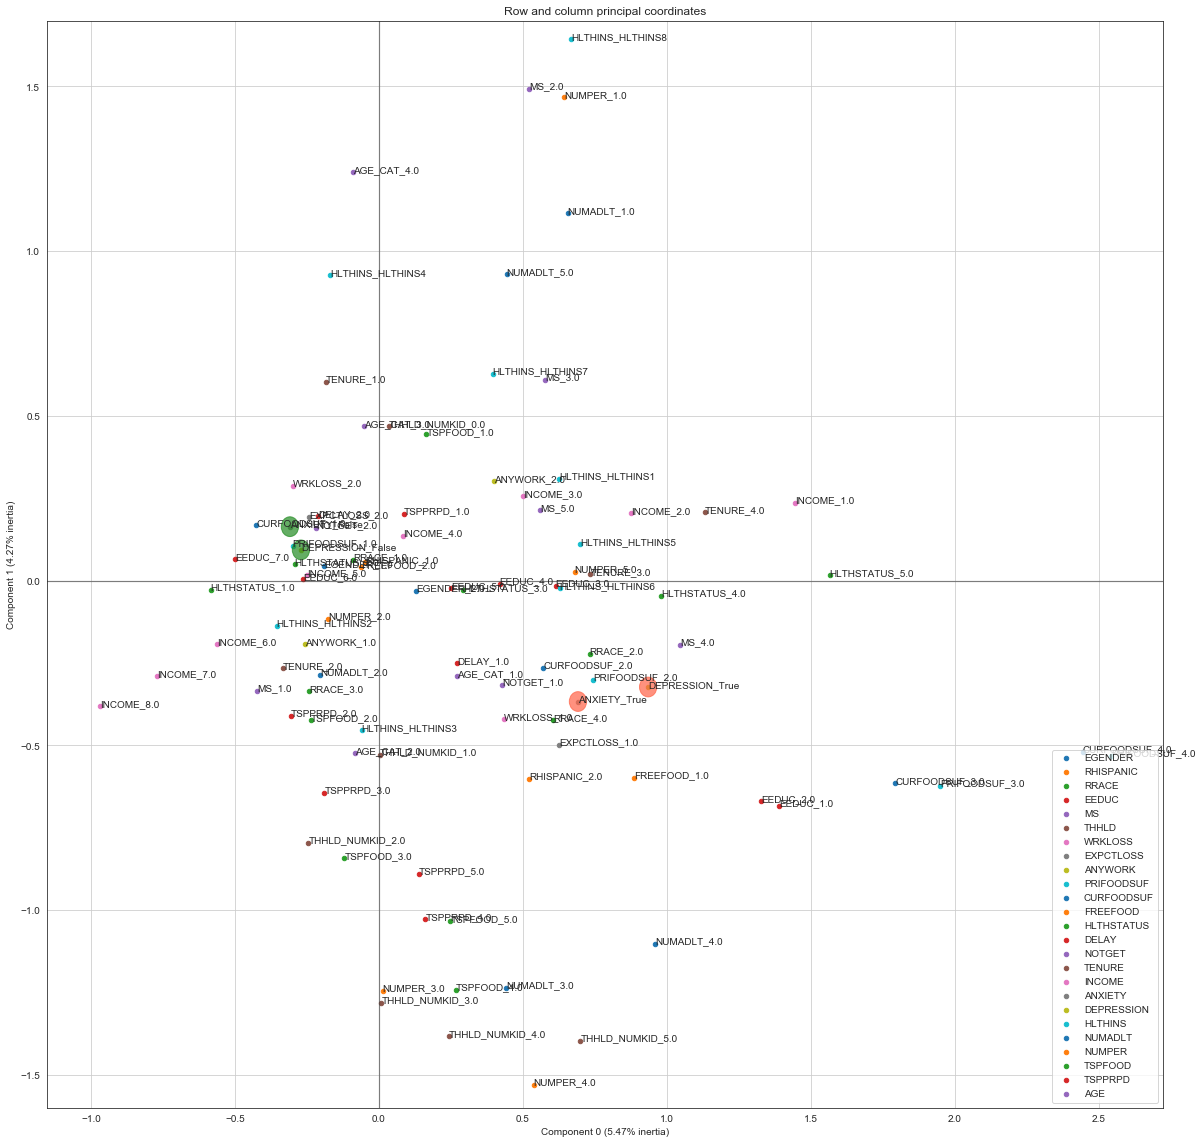

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

sns.set_style("ticks")
ax = mca_ex.plot_coordinates(
                            X=df1,
                            ax=None,
                            figsize=(20, 20),
                            show_row_points=False,
                            row_points_size=10,
                            show_row_labels=False,
                            show_column_points=True,
                            column_points_size=20,
                            show_column_labels=True,
                            legend_n_cols=1)
ax.get_figure().savefig('mca_coordinates.svg')
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.legend(loc='lower right')

cir = plt.Circle(df_variables_mca.loc['ANXIETY_YES', :], 0.03, color='tomato',fill=True, alpha=0.7)
cir1 = plt.Circle(df_variables_mca.loc['ANXIETY_NO', :], 0.03, color='forestgreen',fill=True, alpha=0.7)
cir2 = plt.Circle(df_variables_mca.loc['DEPRESSION_YES', :], 0.03, color='tomato',fill=True, alpha=0.7)
cir3 = plt.Circle(df_variables_mca.loc['DEPRESSION_NO', :], 0.03, color='forestgreen',fill=True, alpha=0.7)
#ax.set_aspect('equal', adjustable='datalim')
ax.add_patch(cir)
ax.add_patch(cir1)
ax.add_patch(cir2)
ax.add_patch(cir3)
ax.set_ylim(-1.6, 1.7)
# ax.set_xlim(-0.02, 1.7)

plt.show()

### 2. Plot datapoints

In [95]:
df1_codes = df1.replace(
                {
                'EGENDER': {1.0: 'Man', 2.0: 'Woman'},
                'RHISPANIC': {1.0: 'No latino', 2.0: 'Latino'},
                'INCOME': {1.0: 'Less than $25,000',
                           2.0: 'Between $25,000- $34,999',
                           3.0: 'Between $35,000- $49,999',
                           4.0: 'Between $50,000- $74,999',
                           5.0: 'Between $75,000- $99,999',
                           6.0: 'Between $100,000- $149,999',
                           7.0: 'Between $150,000- $199,999',
                           8.0: '$200,000 and above'},
                'HLTHSTATUS': {1.0: 'Excellent', 2.0: 'Very good', 3.0: 'Good', 4.0: 'Fair', 5.0: 'Poor'},
                'TENURE': {1.0: 'Owned', 2.0: 'Owned+loan', 3.0: 'Rented', 4.0:'Occupied no payment'},
                'NOTGET': {1.0: 'Yes', 2.0: 'No'},
                'DELAY': {1.0: 'Yes', 2.0: 'No'},
                'CURFOODSUF': {1.0: 'Enough what they want to eat', 
                               2.0: 'Enough, not always what they want to eat', 
                               3.0: 'Sometimes not enough', 
                               4.0: 'Often not enough'},
                'AGE_CAT': {1.0: '<36 yrs', 
                            2.0: 'Between 36-54 yrs', 
                            3.0: 'Between 54-72 yrs', 
                            4.0: '>= 72 yrs'}
                })

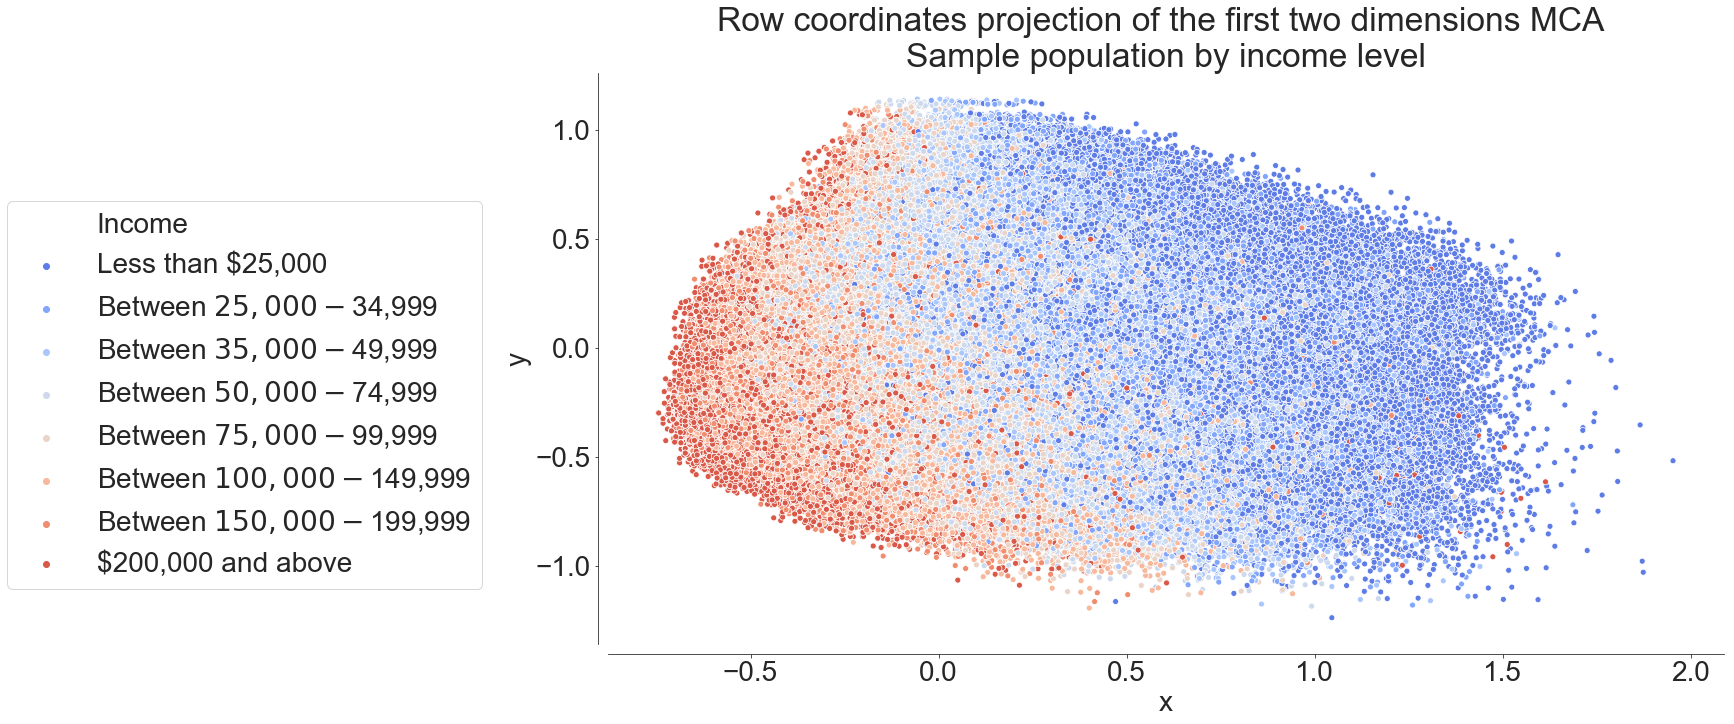

In [97]:
df_mca = pd.DataFrame({'id': df1_codes.index,
                       'Income': df1_codes.INCOME,
                       'Gender': df1_codes.EGENDER,
                       'Age': df1_codes.AGE_CAT,
                       'Tenure': df1_codes.TENURE,
                       'ANXIETY': df1_codes.ANXIETY,
                       'DEPRESSION': df1_codes.DEPRESSION,
                       'Not_get': df1_codes.NOTGET,
                       'Delay':  df1_codes.DELAY,
                       'Health_status': df1_codes.HLTHSTATUS,
                       'Food_sufficiency': df1_codes.CURFOODSUF,
                       'x': dfmca[0], 
                       'y': dfmca[1]})

f, ax = plt.subplots(figsize=(20, 10.5))
#_ = sns.despine(f, left=True, bottom=True)
_ = sns.despine(f, offset=10);
_ = sns.scatterplot(x='x', y='y', hue='Income', hue_order= ["Less than $25,000", 
                                                            "Between $25,000- $34,999", 
                                                            'Between $35,000- $49,999', 
                                                            "Between $50,000- $74,999", 
                                                            "Between $75,000- $99,999", 
                                                            "Between $100,000- $149,999", 
                                                            "Between $150,000- $199,999", 
                                                            "$200,000 and above"],
                    data=df_mca, palette='coolwarm')
_ = plt.title('Row coordinates projection of the first two dimensions MCA \nSample population by income level')
ax.legend(bbox_to_anchor=(-0.1, 0.8), loc='upper right')
_ = plt.rcParams.update({'font.size': 30})
_ = plt.show()

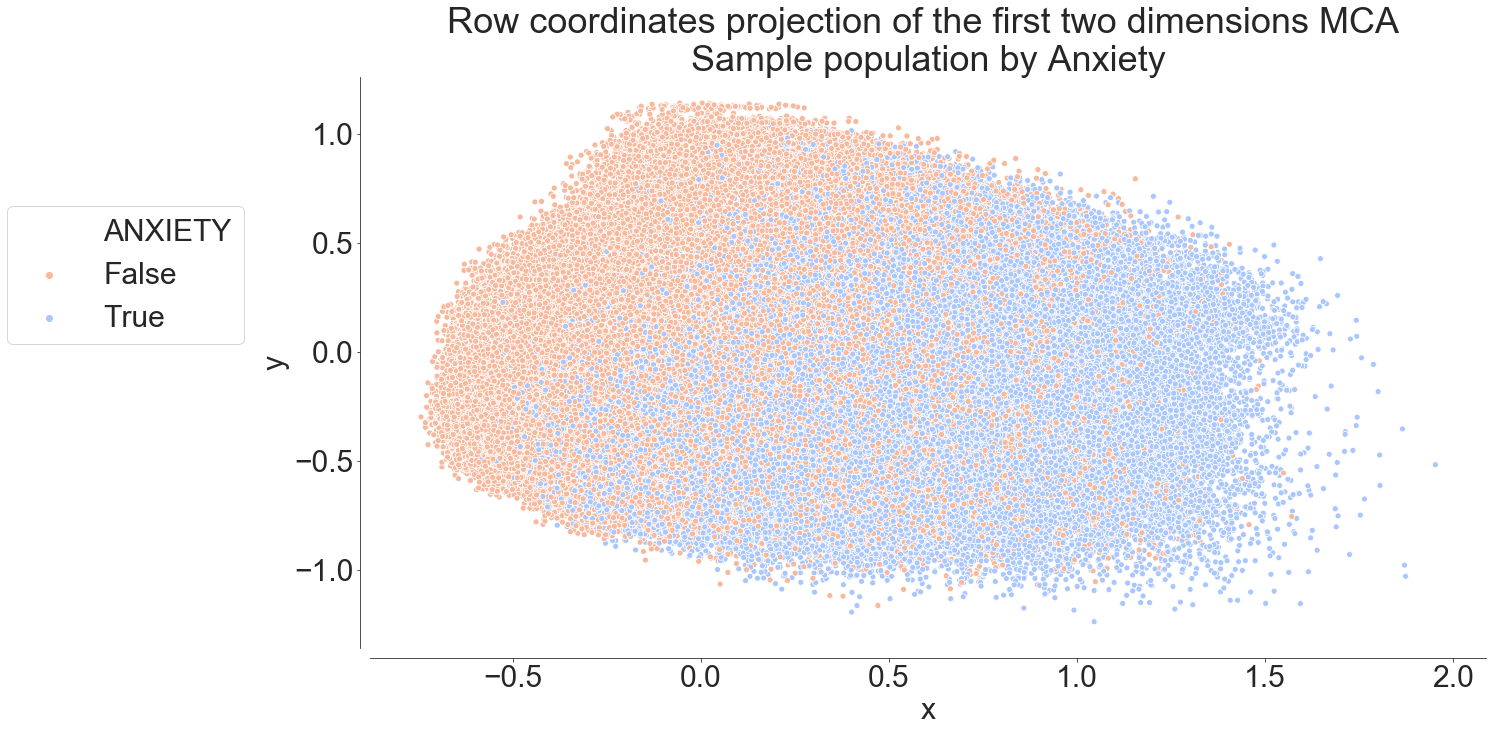

In [98]:
f, ax = plt.subplots(figsize=(20, 10.5))
#_ = sns.despine(f, left=True, bottom=True)
_ = sns.despine(f, offset=10);
_ = sns.scatterplot(x='x', y='y', hue='ANXIETY',
                    data=df_mca, palette='coolwarm_r')
_ = plt.title('Row coordinates projection of the first two dimensions MCA \nSample population by Anxiety')
ax.legend(bbox_to_anchor=(-0.1, 0.8), loc='upper right')
_ = plt.rcParams.update({'font.size': 28})
_ = plt.show()

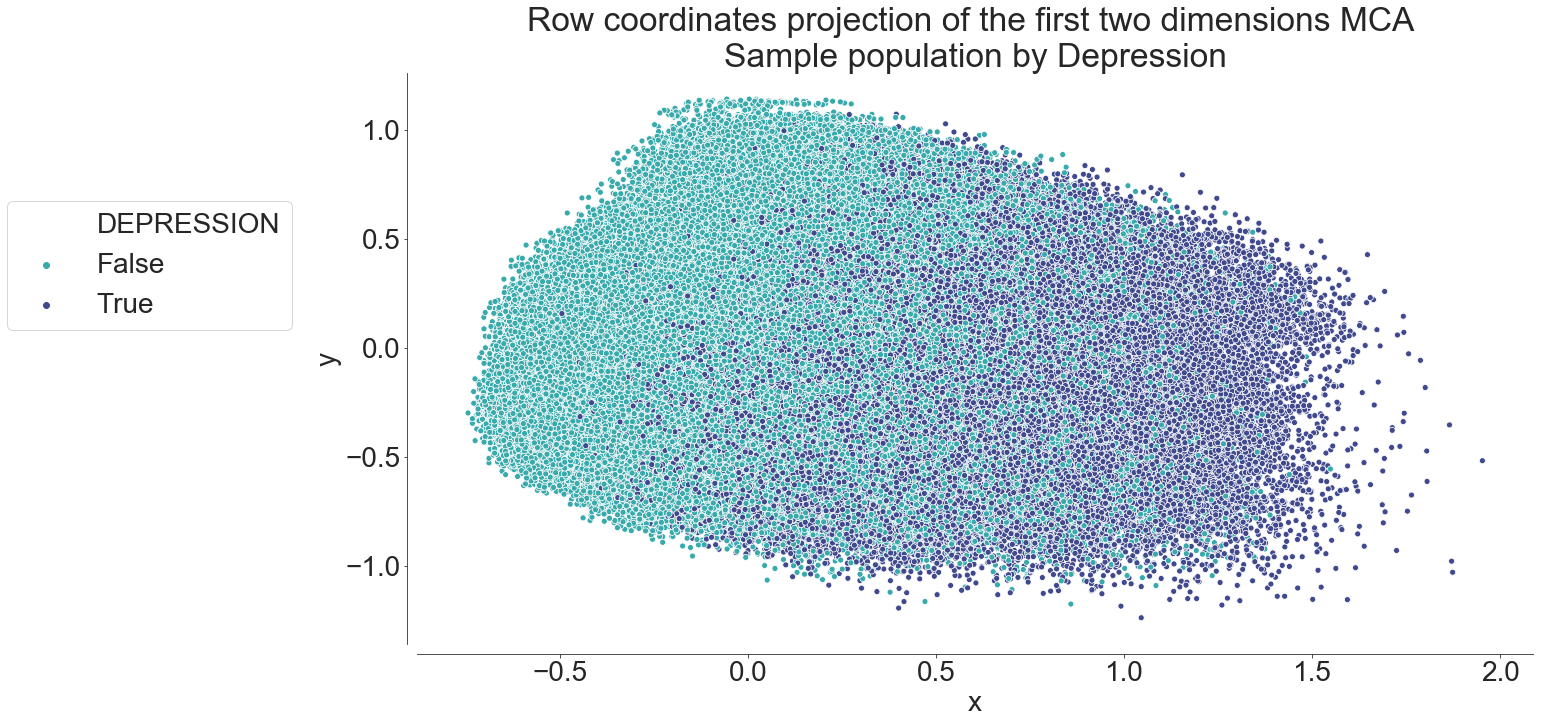

In [99]:
f, ax = plt.subplots(figsize=(20, 10.5))
#_ = sns.despine(f, left=True, bottom=True)
_ = sns.despine(f, offset=10);
_ = sns.scatterplot(x='x', y='y', hue='DEPRESSION',
                    data=df_mca, palette='mako_r')
_ = plt.title('Row coordinates projection of the first two dimensions MCA \nSample population by Depression')
ax.legend(bbox_to_anchor=(-0.1, 0.8), loc='upper right')
_ = plt.rcParams.update({'font.size': 28})
_ = plt.show()

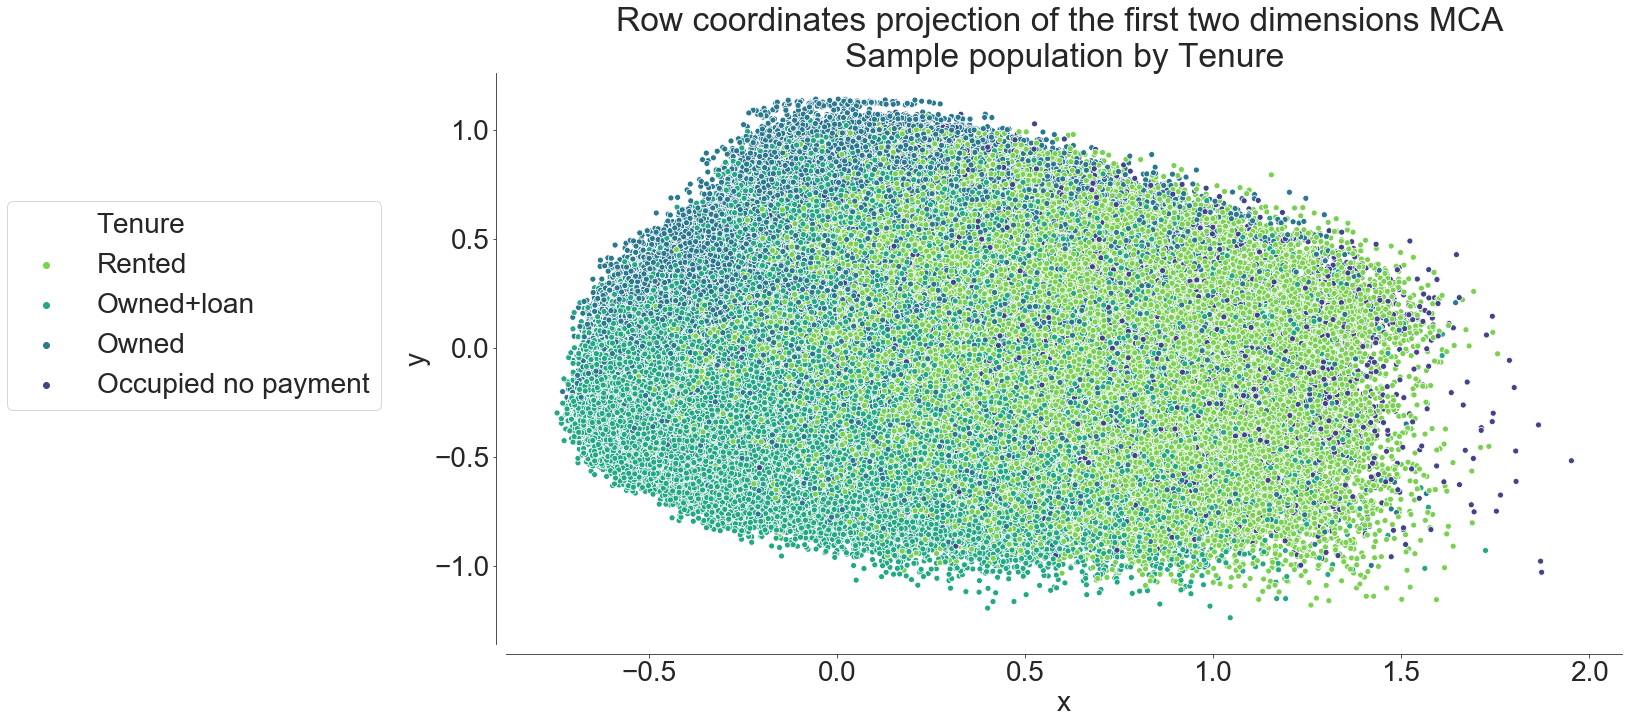

In [100]:
f, ax = plt.subplots(figsize=(20, 10.5))
#_ = sns.despine(f, left=True, bottom=True)
_ = sns.despine(f, offset=10);
_ = sns.scatterplot(x='x', y='y', hue='Tenure',
                    data=df_mca, palette='viridis_r')
_ = plt.title('Row coordinates projection of the first two dimensions MCA \nSample population by Tenure')
ax.legend(bbox_to_anchor=(-0.1, 0.8), loc='upper right')
_ = plt.rcParams.update({'font.size': 28})
_ = plt.show()

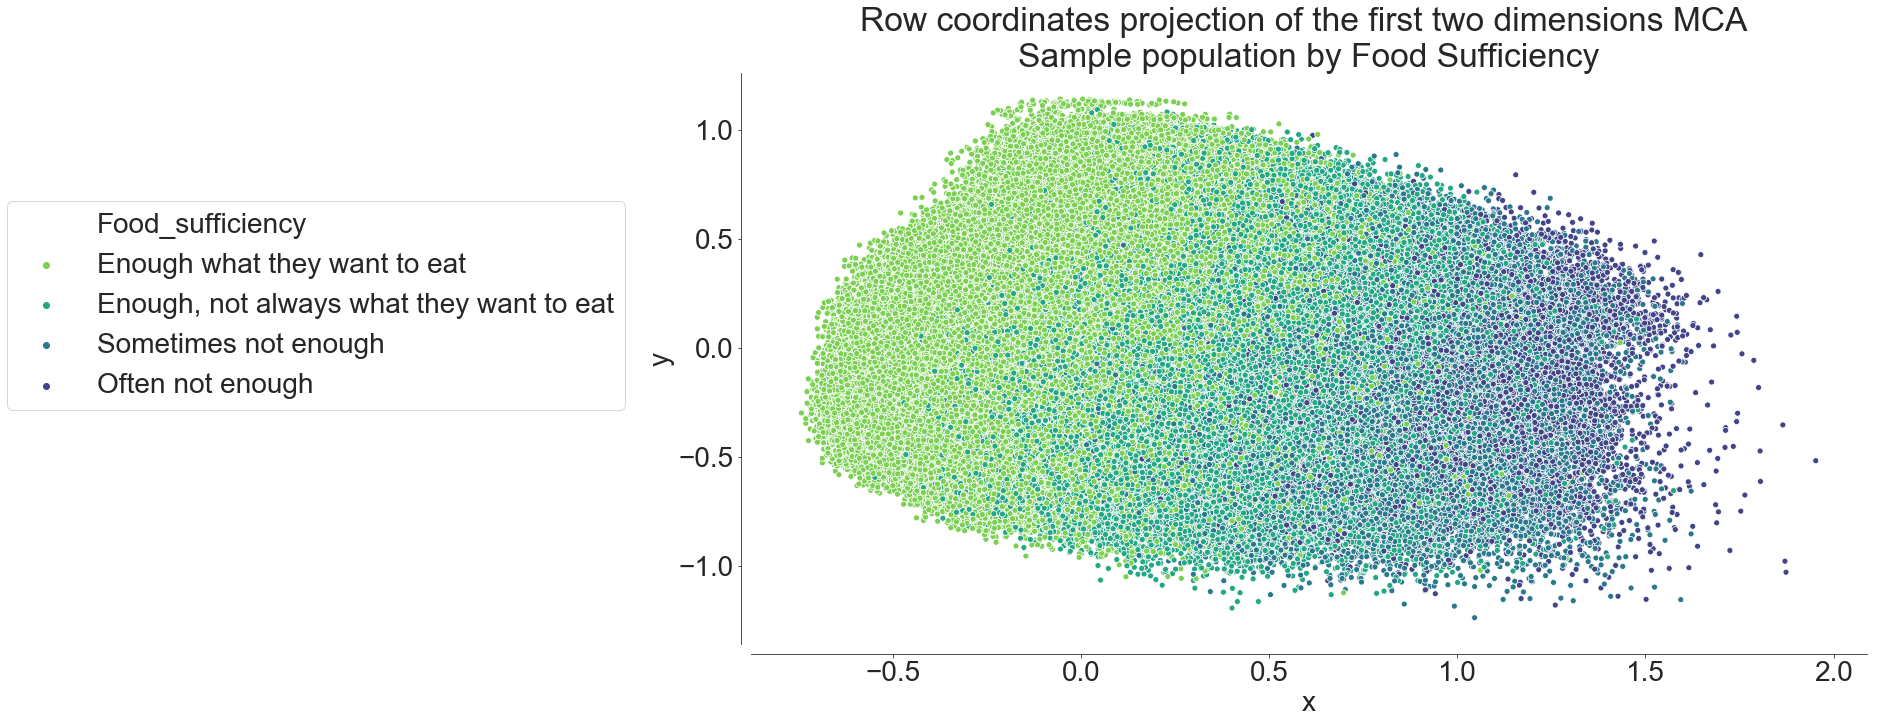

In [101]:
f, ax = plt.subplots(figsize=(20, 10.5))
#_ = sns.despine(f, left=True, bottom=True)
_ = sns.despine(f, offset=10);
_ = sns.scatterplot(x='x', y='y', hue='Food_sufficiency', hue_order = ['Enough what they want to eat', 
                                                                       'Enough, not always what they want to eat', 
                                                                       'Sometimes not enough', 
                                                                       'Often not enough'],
                    data=df_mca, palette='viridis_r')
_ = plt.title('Row coordinates projection of the first two dimensions MCA \nSample population by Food Sufficiency')
ax.legend(bbox_to_anchor=(-0.1, 0.8), loc='upper right')
_ = plt.rcParams.update({'font.size': 28})
_ = plt.show()